## Imports

In [1]:
# Imports
import wikipedia
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import re
import requests
from bs4 import BeautifulSoup
import seaborn as sns

## Functions

In [2]:
# From https://stackoverflow.com/questions/18916616/get-first-link-of-wikipedia-article-using-wikipedia-api
def isValid(ref,paragraph):
   if not ref or "#" in ref or "//" in ref or ":" in ref:
      return False
   if "/wiki/" not in ref:
      return False
   if ref not in paragraph:
      return False
   prefix = paragraph.split(ref,1)[0]
   if prefix.count("(")!=prefix.count(")"):
      return False
   return True

In [3]:
help_link_regex = re.compile("^/wiki/Help:")


# Gets the "first link" from a wikipedia page using the full URL
# Help from https://stackoverflow.com/questions/54170998/crawl-the-first-paragraph-link-in-wiki
def get_first_link(page_url, help_link_regex=help_link_regex):
    # Get page
    response = requests.get(page_url)
    html = response.text

    # Help from https://stackoverflow.com/questions/72251687/get-the-first-regular-link-that-is-not-located-between-brackets-out-of-a-paragra
    soup = BeautifulSoup(html, "html.parser")

    # Many pages lack a first link or have a strange structure requiring a lot of try statements
    try:
        # Paragraphs of the page
        paragraphs = (
            soup.find(id="mw-content-text").find(class_="mw-parser-output").find_all("p", recursive=False)
        )

        # Find all links in the first paragraph
        if len(paragraphs) > 5:
            filtered_paragaphs = [p for p in paragraphs[:4] if len(p) > 1]
        else:
            filtered_paragaphs = [p for p in paragraphs if len(p) > 1]

        link_list = []

        for p in filtered_paragaphs:
            p_links = p.find_all("a")

            # Leave them out if they match the previous RegEx
            for link in p_links:
                if not help_link_regex.match(link.get("href")):
                    href = str(link.get("href"))
                    link_class = str(link.get("class"))
                    # print(link_class)

                    # Pages that start with # wrongly redirect to the homepage
                    if href.startswith('#'):
                        href = href.lstrip("#")

                    # Filters out bad links in wikipedia pages
                    if (
                        href != None
                        and not href.endswith('.ogg')
                        and not href.endswith("Wikipedia:Please_clarify")
                        and "#cite_note" not in href
                        and "upload.wikimedia.org" not in href
                        and link_class != "['extiw']"
                        and not href.startswith("file:")
                        and not href.startswith("https://geohack.toolforge.org/")
                        and not href.startswith("special:")
                        and not href.startswith("/w/index.php?")
                        and not href.startswith("cite_note")
                        and isValid(href, str(p))
                    ):
                        link_list.append(href)
                        # break

        try:
            first_link = link_list[0]

            # Cleaning the name
            if '/wiki/' in first_link:
                first_link_output = first_link.split("/wiki/", 1)[1]
            else:
                first_link_output = first_link
            return first_link_output

        # If it has no links, it is disconnected
        except IndexError:
            # NO LINKS
            original_name = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
            return original_name

    # These errors get manually checked
    except (AttributeError, TypeError) as error:
        # NO LINKS
        fail_output = "!FAIL!: " + page_url
        return fail_output


In [4]:
# Testing the function. It should be 'Private_university'

get_first_link("https://en.wikipedia.org/wiki/georgetown_university")

'Private_university'

In [5]:
help_link_regex = re.compile("^/wiki/Help:")


# Gets the "second link" from a wikipedia page using the full URL
# The same as the first link function it just gets the second link
# Help from https://stackoverflow.com/questions/54170998/crawl-the-first-paragraph-link-in-wiki
def get_second_link(page_url, help_link_regex=help_link_regex):
    # Get page
    response = requests.get(page_url)
    html = response.text
    soup = BeautifulSoup(html, "html.parser")

    # Many pages lack a first link or have a strange structure requiring a lot of try statements
    try:
        # Paragraphs of the page
        paragraphs = (
            soup.find(id="mw-content-text").find(class_="mw-parser-output").find_all("p", recursive=False)
        )

        # Find all links in the first paragraph
        if len(paragraphs) > 5:
            filtered_paragaphs = [p for p in paragraphs[:4] if len(p) > 1]
        else:
            filtered_paragaphs = [p for p in paragraphs if len(p) > 1]

        link_list = []

        for p in filtered_paragaphs:
            p_links = p.find_all("a")
            # Leave them out if they match the previous RegEx
            for link in p_links:
                if not help_link_regex.match(link.get("href")):
                    href = str(link.get("href"))
                    link_class = str(link.get("class"))
                    # print(link_class)

                    # Pages that start with # wrongly redirect to the homepage
                    if href.startswith('#'):
                        href = href.lstrip("#")

                    # Filters out bad links in wikipedia pages
                    if (
                        href != None
                        and not href.endswith('.ogg')
                        and not href.endswith("Wikipedia:Please_clarify")
                        and "#cite_note" not in href
                        and "upload.wikimedia.org" not in href\
                        # and link_class != "['mw-redirect']" # Redirects don't work since it returns a blank HTML
                        and link_class != "['extiw']"
                        and not href.startswith("file:")
                        and not href.startswith("https://geohack.toolforge.org/")
                        and not href.startswith("special:")
                        and not href.startswith("/w/index.php?")
                        and not href.startswith("cite_note")
                        and isValid(href, str(p))
                    ):
                        link_list.append(href)

                        if len(link_list) > 2:
                            break
            try:
                first_link = link_list[1]

                # Cleaning the name
                if '/wiki/' in first_link:
                    first_link_output = first_link.split("/wiki/", 1)[1]
                else:
                    first_link_output = first_link
                return first_link_output

            # If it has no links, it is disconnected
            except IndexError:
                # NO LINKS
                original_name = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
                return original_name

    # These errors get manually checked
    except (AttributeError, TypeError) as error:
        # NO LINKS
        fail_output = "!FAIL!: " + page_url
        return fail_output


In [6]:
# Testing the function. It should be 'Society_of_Jesus'
get_second_link("https://en.wikipedia.org/wiki/georgetown_university")

'Society_of_Jesus'

In [7]:
# Function that computes how far the average page is from the Philosophy page
import statistics
def avg_dist_from_phil(G):
    distance_from_phil = []

    # Get nodes connected to "philosophy"
    connected_nodes = [node for node in G.nodes if nx.has_path(G, node, "philosophy")]

    for node in connected_nodes:

        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        distance_from_phil.append(shortest_path_length)

    # Return the mean
    return statistics.mean(distance_from_phil)


In [8]:
# Function that finds a new random page on Wikipedia
def wiki_random_page(seen_pages):

    # Set up while loop that searches 
    already_seen_page = True

    while already_seen_page:

        # Use the wikipedia api to find a random page
        random_page = wikipedia.random()
        
        # If it has already seen the page, go back up and try again
        if random_page in seen_pages:
            already_seen_page = True
            continue

        # Ignoring pages that are just lists of other pages and disambiguation because they are not 'real' wikipedia pages used for understanding a topic
        elif "list of " in random_page.lower() or "list_of" in random_page.lower():
            already_seen_page = True
        
        elif '(disambiguation)' in random_page.lower():
            already_seen_page = True

        # If it is a new page, return the page and its url
        else:
            page_url = "https://en.wikipedia.org/wiki/" + random_page.replace(" ", "_")
            already_seen_page = False

    return random_page, page_url

In [10]:
# Testing the function
seen_pages = ['philosophy']
wiki_random_page(seen_pages)

('1981 hurricane season',
 'https://en.wikipedia.org/wiki/1981_hurricane_season')

## Creating the First-Link Network

In [11]:
# Create Graph
G = nx.DiGraph()

# Add Philosophy as the first node
G.add_node("philosophy")

# Starting page, can be anything. I think Georgetown is a fun starting point but wikipedia.random() would work just as well
seed_page = "Georgetown University"
seed_page = seed_page.replace(" ", "_").lower()
is_root = True

# These start as the same thing
root_page = seed_page

# Create first url
first_page_url = "https://en.wikipedia.org/wiki/" + seed_page
old_page = seed_page

# List of pages already hit. This avoids finding the same paths for pages we already know.
seen_pages = ["philosophy"]

# List of fails
fails = []

# Not connected to philosophy
disconnects = []

# Create a dataframe that will be used to demonstrate the convergence of important pages
convergence_df = pd.DataFrame(columns=["iteration", "node", "betweeness_centrality", "closeness_centrality", "in_degree", "avg_dist_from_phil", "size_of_gcc"])

In [12]:
def gcc_fraction(G):
    # Get all strongly connected components as subgraphs
    sccs = list(nx.weakly_connected_components(G))

    sorted_scc = sorted(sccs, key=len, reverse=True)
    # Find the largest strongly connected component (GCC)
    gcc_nodes = sorted_scc[0]

    # Create a subgraph containing only nodes from the GCC
    gcc = G.subgraph(gcc_nodes)

    fraction = (len(gcc.nodes()) / len(G.nodes()))

    return fraction

In [13]:
# Function to expand the network
# New pages is the number of random pages that will be added to the network. All of the pages between these new pages and philosophy will also be added
def network_expander(G, page_url, seen_pages, is_root, fails, disconnects, convergence_df, new_pages=100):

    # If the DF already exists, this will be used later to ensure the iteration value is accurate
    start_iteration = len(convergence_df.index)

    # From experience, these are the most notable pages I want to focus on. If their centrality has converged, we can stop expanding the network
    notable_nodes = ["philosophy", "awareness", "knowledge", "science", "language", "philosophy_of_logic"]

    # Remove the link extra to get a cleaner page name
    root_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
    
    # Pretty display of function progress 
    # Help from https://stackoverflow.com/questions/57473107/how-to-set-the-r-bar-part-of-tqdm
    for i in tqdm(range(new_pages), desc="Finding Paths", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", colour="Green", ncols=75):
        # Get the first link
        # print(page_url)
        full_first_link = get_first_link(page_url=page_url)

        if full_first_link is None:
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it has nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(full_first_link)
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                is_root = True
                continue

        # Get the cleaner name for the node
        first_link = full_first_link.lower()
        
        if first_link == "philosophical": first_link = "philosophy"

        # If it fails, find try a new random page
        if "!FAIL!: " in str(full_first_link):
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(first_link)
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                is_root = True
                continue
                
        elif "DEAD END: " in str(full_first_link):
            # print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            continue

        # Add node
        G.add_node(first_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, first_link)
        
        # Every 100 iterations, once all of the notable nodes have been hit, check their key statistics
        if i % 100 == 0 and all([True if node in G.nodes else False for node in notable_nodes]):

            # Calculate values
            new_between_cent = {node: val for node, val in nx.betweenness_centrality(G, endpoints='philosophy').items() if node in notable_nodes}
            new_closeness_cent = {node: val for node, val in nx.closeness_centrality(G).items() if node in notable_nodes}
            new_in_degree_cent = {node: val for node, val in nx.in_degree_centrality(G).items() if node in notable_nodes}
            
            # Calculate average distance
            new_avg_dist = avg_dist_from_phil(G)

            # Size of GCC
            size_of_gcc = gcc_fraction(G)

            # Function may take existing list, calculated at beginning of function
            iteration = start_iteration + i

            # Each node gets a row, these get filtered by the hue in the plots
            for node in notable_nodes:
                new_row = [iteration, node, new_between_cent[node], new_closeness_cent[node], new_in_degree_cent[node], new_avg_dist, size_of_gcc]
                convergence_df.loc[len(convergence_df.index)] = new_row


        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Page did a self loop! Not connected to philosophy
        elif first_link == root_page:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/wiki/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link
            is_root = False

    # Return key values
    return G, seen_pages, fails, disconnects, convergence_df


In [14]:
# Running the function
G, seen_pages, fails, disconnects, convergence_df = network_expander(
    G,
    page_url=first_page_url,
    seen_pages=seen_pages,
    is_root=True,
    fails=fails,
    disconnects=disconnects,
    convergence_df=convergence_df,
    new_pages=1000,
)

Finding Paths: 100%|████████████████████████████████████████████| 1000/1000


In [12]:
fails = [fail for fail in fails if fail != None]
fails

[]

In [13]:
# Viewing the Convergence DF
convergence_df

iteration                 node  betweeness_centrality  \
0          200           philosophy               0.005151   
1          200            awareness               0.009085   
2          200            knowledge               0.009885   
3          200              science               0.004281   
4          200             language               0.001427   
..         ...                  ...                    ...   
583       9900            awareness               0.000238   
584       9900            knowledge               0.000284   
585       9900              science               0.000192   
586       9900             language               0.000047   
587       9900  philosophy_of_logic               0.000026   

     closeness_centrality  in_degree  avg_dist_from_phil  size_of_gcc  
0                0.111157   0.011834            7.825503     0.876471  
1                0.107527   0.011834            7.825503     0.876471  
2                0.096110   0.029586            7.825503     0.876471  
3                0.046308   0.017751            7.825503     0.876471  
4                0.009862   0.005917            7.825503     0.876471  
..                    ...        ...                 ...          ...  
583              0.049991   0.000339           14.348936     0.797286  
584              0.040835   0.001188           14.348936     0.797286  
585              0.044193   0.003393           14.348936     0.797286  
586              0.008238   0.001866           14.348936     0.797286  
587              0.008188   0.000170           14.348936     0.797286  

[588 rows x 7 columns]

In [ ]:
def fail_fixer(G, fail, next_link, seen_pages):
    clean_name = fail.lstrip("!fail!: ")
    G = nx.relabel_nodes(G, {fail:clean_name})
    G.add_node(next_link)
    G.add_edge(clean_name, next_link)

    page_url = "https://en.wikipedia.org/wiki/" + next_link

    if next_link != "philosophy":
        philosophy_page = False
        old_page = next_link
    else: philosophy_page = True

    while not philosophy_page:
        full_first_link = get_first_link(page_url=page_url)
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            philosophy_page = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            philosophy_page = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link

    # Making sure it worked
    try:
        nx.shortest_path(G, fail, "philosophy")

    except nx.NodeNotFound:
        print("FAILED")

    return G, seen_pages

In [ ]:
G, seen_pages = fail_fixer(G, fail='!fail!: crime city', next_link="crime_film", seen_pages=seen_pages)

In [14]:
# Saving the network and DataFrame
first_link_path = './data/first-links-10000.gml'
nx.write_gml(G, first_link_path)

convergence_df.to_csv("./data/convergence_data-10000.csv")

### Second Link Functions

In [8]:
# Create Second-Link Graph
G2 = nx.DiGraph()

# Starting page, can be anything. I think Georgetown is a fun starting point but wikipedia.random() would work just as well
seed_page = "Georgetown University"
seed_page = seed_page.replace(" ", "_").lower()
is_root = True

# Adding first node
G2.add_node(seed_page)

# These start as the same thing
root_page = seed_page

# Create first url
first_page_url = "https://en.wikipedia.org/wiki/" + seed_page
old_page = seed_page

# List of pages already hit. This avoids finding the same paths for pages we already know.
second_link_seen_pages = [seed_page]

# List of fails
second_link_fails = []

# Dead ends: pages with no second link
second_link_disconnects = []

# Create a dataframe that will be used to demonstrate the convergence of important pages
# This one does not have an average distance from philosophy as there is no guarantee we even hit that page
convergence_df2 = pd.DataFrame(columns=["iteration", "node", "betweeness_centrality", "closeness_centrality", "in_degree"])

## Creating the Second Link Network

In [7]:
import heapq
# Function to expand the network
# New pages is the number of random pages that will be added to the network. All of the pages between these new pages and philosophy will also be added
def second_link_network_expander(G, page_url, seen_pages, is_root, fails, disconnects, convergence_df, new_pages=100):

    # If the DF already exists, this will be used later to ensure the iteration value is accurate
    start_iteration = len(convergence_df.index)

    # Remove the link extra to get a cleaner page name
    root_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
    
    # Pretty display of function progress 
    # Help from https://stackoverflow.com/questions/57473107/how-to-set-the-r-bar-part-of-tqdm
    for i in tqdm(range(new_pages), desc="Finding Paths", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", colour="Green", ncols=75):
        first_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
        pages_hit = [first_page]

        # Get the second link
        # print(page_url)
        full_second_link = get_second_link(page_url=page_url)

        if full_second_link is None:
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it has nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(full_second_link)
                # print(full_second_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_second_link = get_second_link(page_url=page_url)
                is_root = True
                continue

         # Get the cleaner name for the node
        second_link = full_second_link.lower()

        # If it fails, find try a new random page
        if "!FAIL!: " in str(full_second_link):
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)
                continue

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(second_link)
                # print(full_second_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_second_link = get_second_link(page_url=page_url)
                is_root = True
                continue
                
        elif "DEAD END: " in str(full_second_link):
            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            continue

        # Add node
        G.add_node(second_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, second_link)
        
        # Every 100 iterations check the top 5 in key statistics
        if i >=3000 and i % 100 == 0:

            # Calculate values
            new_between_cent = {node: val for node, val in nx.betweenness_centrality(G, endpoints='philosophy').items()}
            new_closeness_cent = {node: val for node, val in nx.closeness_centrality(G).items()}
            new_in_degree_cent = {node: val for node, val in nx.in_degree_centrality(G).items()}
            
            # Get the top 5 nodes for each centrality measure
            top_3_between = heapq.nlargest(3, new_between_cent, key=new_between_cent.get)
            top_3_closeness = heapq.nlargest(3, new_closeness_cent, key=new_closeness_cent.get)
            top_3_in_degree = heapq.nlargest(3, new_in_degree_cent, key=new_in_degree_cent.get)

            # Combine all top 5 nodes into a single list
            notable_nodes = top_3_between + top_3_closeness + top_3_in_degree           

            # Remove duplicates by converting to a set and back to a list
            notable_nodes = list(set(notable_nodes))

            # Function may take existing list, calculated at beginning of function
            iteration = start_iteration + i

            # Each node gets a row, these get filtered by the hue in the plots
            for node in notable_nodes:
                new_row = [iteration, node, new_between_cent[node], new_closeness_cent[node], new_in_degree_cent[node]]
                convergence_df.loc[len(convergence_df.index)] = new_row

        # If we have already seen where it goes, new root page
        if second_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Page did a loop! No need to keep repeating it
        elif second_link in pages_hit:
            disconnects.append(root_page)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/wiki/" + full_second_link
            seen_pages.append(second_link)
            pages_hit.append(second_link)
            old_page = second_link
            is_root = False

    # Return key values
    return G, seen_pages, fails, disconnects, convergence_df


In [21]:
# Running the function
G2, second_link_seen_pages, second_link_fails, second_link_disconnects, convergence_df2 = second_link_network_expander(
    G2,
    page_url=first_page_url,
    seen_pages=second_link_seen_pages,
    is_root=True,
    fails=second_link_fails,
    disconnects=second_link_disconnects,
    convergence_df=convergence_df2,
    new_pages=10000,
)

Finding Paths: 100%|██████████████████████████████████████████| 10000/10000


In [22]:
# Saving the network and DataFrame
second_link_path = './data/second-links-10000.gml'
nx.write_gml(G2, second_link_path)

convergence_df.to_csv("./data/second-link-convergence-data-10000.csv")

## Analysis

### First Link Convergence

In [2]:
# Reading the data in
first_link_path = './data/first-links-10000.gml'
G = nx.read_gml(first_link_path)

convergence_df = pd.read_csv("./data/convergence_data-10000.csv")
convergence_df.pop("Unnamed: 0")
convergence_df.head()

iteration        node  betweeness_centrality  closeness_centrality  \
0        200  philosophy               0.005151              0.111157   
1        200   awareness               0.009085              0.107527   
2        200   knowledge               0.009885              0.096110   
3        200     science               0.004281              0.046308   
4        200    language               0.001427              0.009862   

   in_degree  avg_dist_from_phil  size_of_gcc  
0   0.011834            7.825503     0.876471  
1   0.011834            7.825503     0.876471  
2   0.029586            7.825503     0.876471  
3   0.017751            7.825503     0.876471  
4   0.005917            7.825503     0.876471

In [4]:
total_iterations = max(convergence_df['iteration'])
last_1000_iterations = convergence_df[convergence_df["iteration"] >= total_iterations - 1000]
last_1000_iterations.reset_index(inplace=True)
last_1000_iterations.head()

index  iteration        node  betweeness_centrality  closeness_centrality  \
0    522       8900  philosophy               0.000149              0.054634   
1    523       8900   awareness               0.000262              0.049065   
2    524       8900   knowledge               0.000311              0.039665   
3    525       8900     science               0.000210              0.044435   
4    526       8900    language               0.000051              0.008160   

   in_degree  avg_dist_from_phil  size_of_gcc  
0   0.002041           14.659333     0.801113  
1   0.000371           14.659333     0.801113  
2   0.001299           14.659333     0.801113  
3   0.003526           14.659333     0.801113  
4   0.002041           14.659333     0.801113

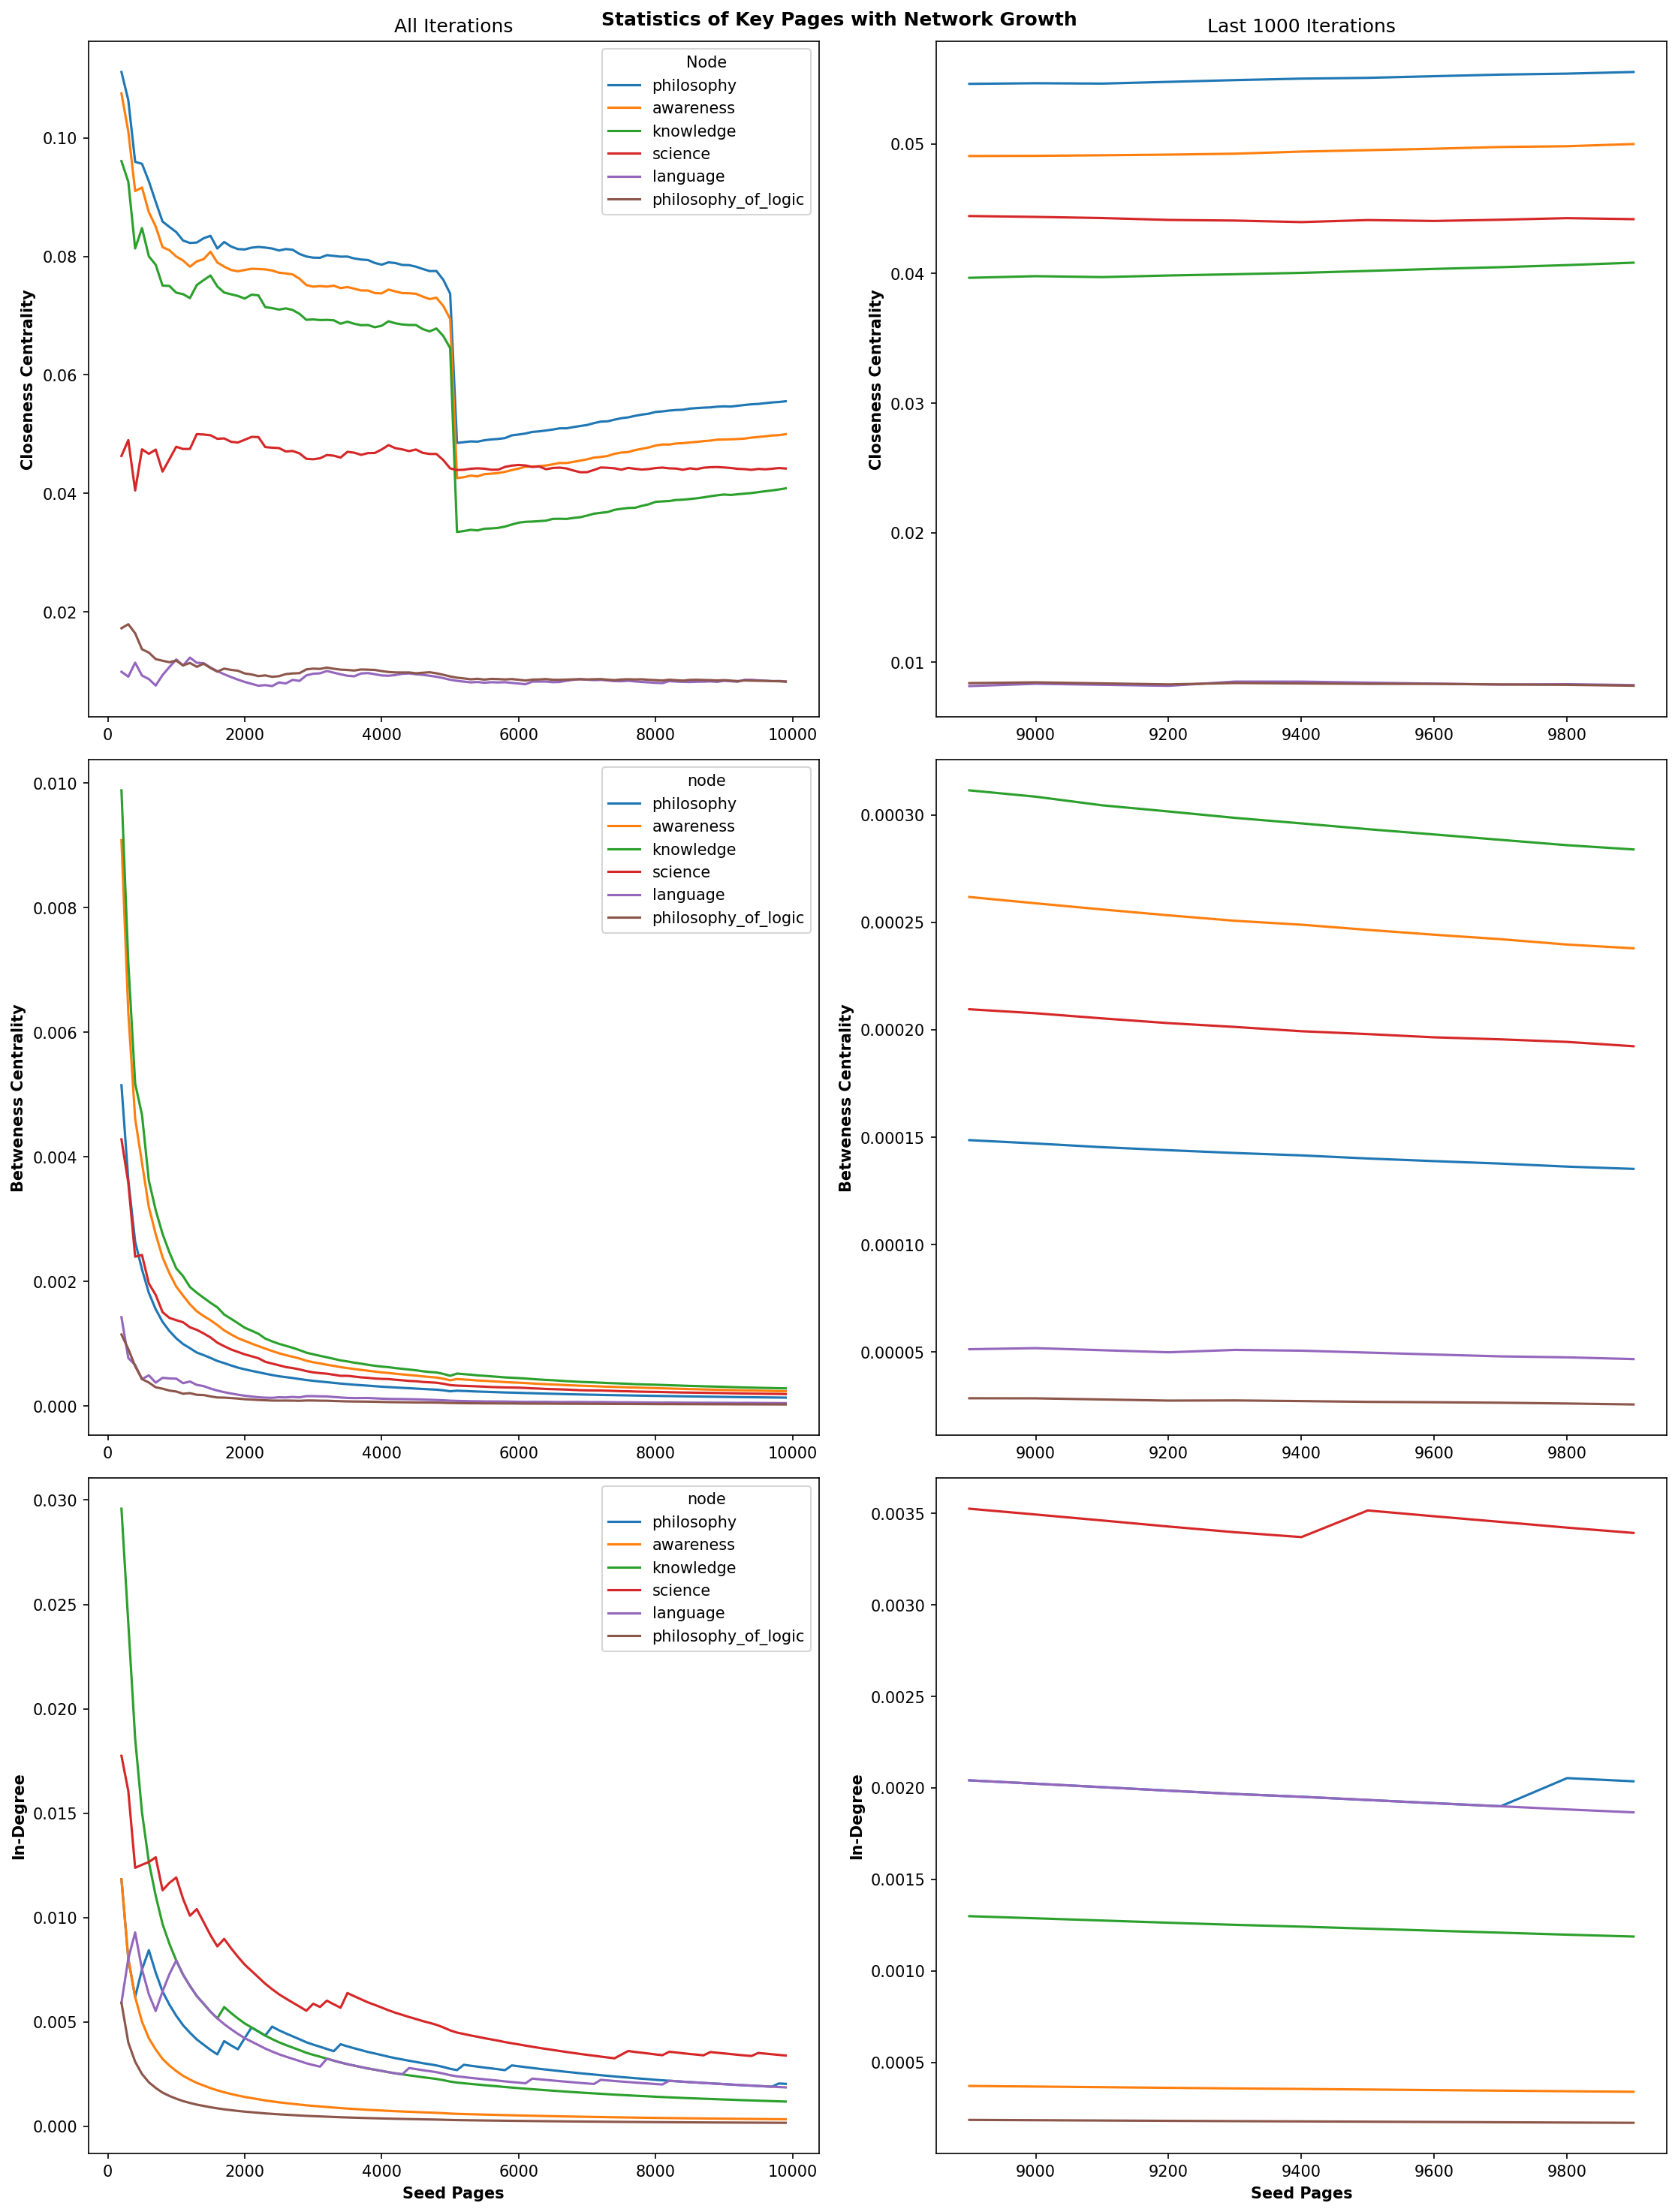

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20), dpi=150)
sns.lineplot(convergence_df, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,0])
axs[0,0].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,0].set_xlabel("")
axs[0,0].set_title("All Iterations")

legend = axs[0,0].legend()
legend.set_title("Node")

sns.lineplot(last_1000_iterations, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,1], legend=False)
axs[0,1].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,1].set_xlabel("")
axs[0,1].set_title("Last 1000 Iterations")

sns.lineplot(convergence_df, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,0])
axs[1,0].set_ylabel("Betweness Centrality", fontweight='bold')
axs[1,0].set_xlabel("")


sns.lineplot(last_1000_iterations, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,1], legend=False)
axs[1,1].set_ylabel("Betweness Centrality", fontweight='bold')
axs[1,1].set_xlabel("")

sns.lineplot(convergence_df, x="iteration", y="in_degree", hue="node", ax=axs[2,0])
axs[2,0].set_ylabel("In-Degree", fontweight='bold')
axs[2,0].set_xlabel("Seed Pages", fontweight='bold')

sns.lineplot(last_1000_iterations, x="iteration", y="in_degree", hue="node", ax=axs[2,1], legend=False)
axs[2,1].set_ylabel("In-Degree", fontweight='bold')
axs[2,1].set_xlabel("Seed Pages", fontweight='bold')


plt.suptitle("Statistics of Key Pages with Network Growth", fontweight='bold')
plt.tight_layout()

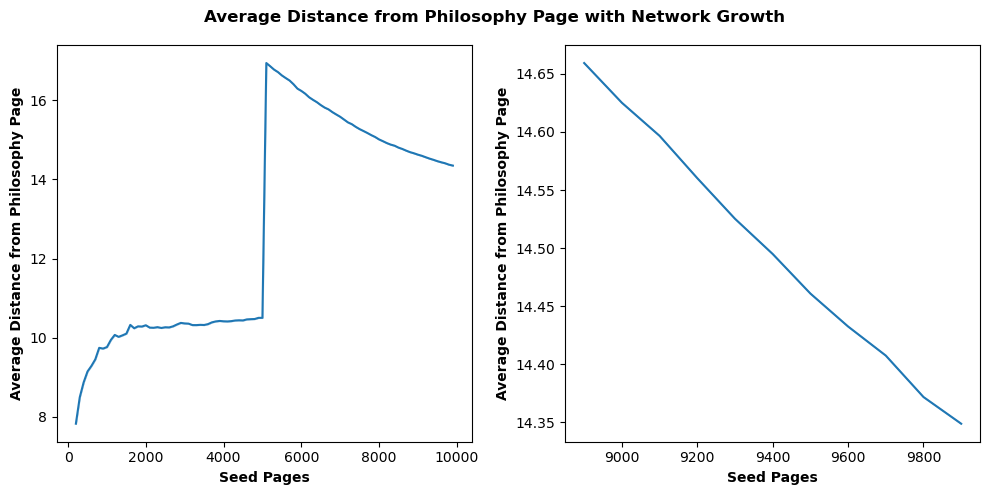

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(convergence_df, x="iteration", y="avg_dist_from_phil", ax=ax1)
ax1.set_ylabel("Average Distance from Philosophy Page", fontweight="bold")
ax1.set_xlabel("Seed Pages", fontweight="bold")


sns.lineplot(last_1000_iterations, x="iteration", y="avg_dist_from_phil", ax=ax2, legend=False)
ax2.set_ylabel("Average Distance from Philosophy Page", fontweight="bold")
ax2.set_xlabel("Seed Pages", fontweight="bold")


plt.suptitle("Average Distance from Philosophy Page with Network Growth", fontweight="bold")
plt.tight_layout()

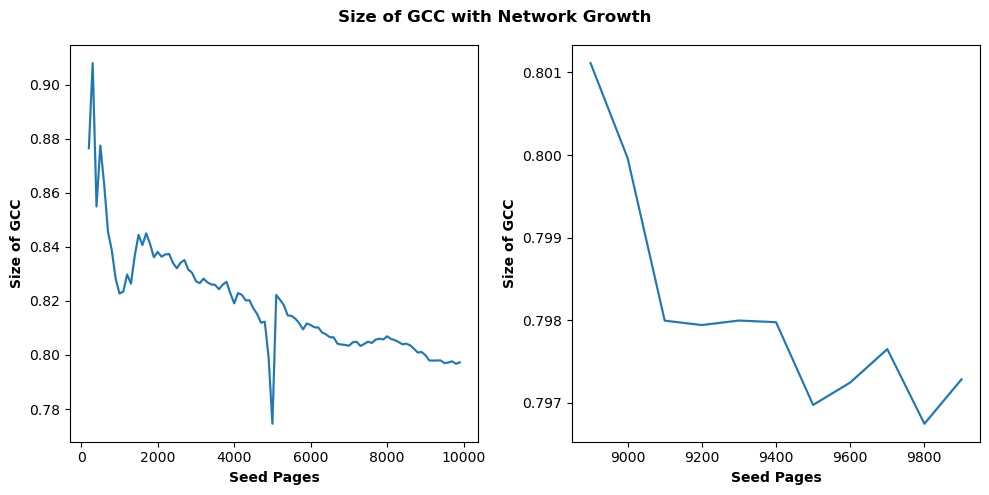

In [8]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(convergence_df, x="iteration", y="size_of_gcc", ax=ax1)
ax1.set_ylabel("Size of GCC", fontweight="bold")
ax1.set_xlabel("Seed Pages", fontweight="bold")


sns.lineplot(last_1000_iterations, x="iteration", y="size_of_gcc", ax=ax2, legend=False)
ax2.set_ylabel("Size of GCC", fontweight="bold")
ax2.set_xlabel("Seed Pages", fontweight="bold")


plt.suptitle("Size of GCC with Network Growth", fontweight="bold")
plt.tight_layout()

### Second Link Convergence

In [3]:
# Reading the data in
second_link_path = './data/second-links.gml'
G2 = nx.read_gml(second_link_path)

second_link_convergence_df = pd.read_csv("./data/second-link-convergence-data.csv")
second_link_convergence_df.pop("Unnamed: 0")
second_link_convergence_df.head()

iteration        node  betweeness_centrality  closeness_centrality  \
0         50  philosophy               0.018174              0.131978   
1         50   awareness               0.013741              0.059840   
2         50   knowledge               0.019504              0.064157   
3         50     science               0.017287              0.038298   
4         50    language               0.015071              0.034043   

   in_degree  avg_dist_from_phil  
0   0.063830            6.452381  
1   0.021277            6.452381  
2   0.042553            6.452381  
3   0.021277            6.452381  
4   0.021277            6.452381

In [24]:
second_link_total_iterations = max(convergence_df2['iteration'])
second_link_last_1000_iterations = convergence_df2[convergence_df2["iteration"] >= second_link_total_iterations - 1000]
second_link_last_1000_iterations.reset_index(inplace=True)
second_link_last_1000_iterations.head()

index  iteration            node  betweeness_centrality  \
0    403       8900          powiat               0.000007   
1    404       8900  ancient_greece               0.000208   
2    405       8900      u.s._state               0.000059   
3    406       8900        language               0.000130   
4    407       8900        alphabet               0.000176   

   closeness_centrality  in_degree  
0              0.006308   0.004846  
1              0.011824   0.000346  
2              0.010919   0.009692  
3              0.011530   0.001731  
4              0.010908   0.000519

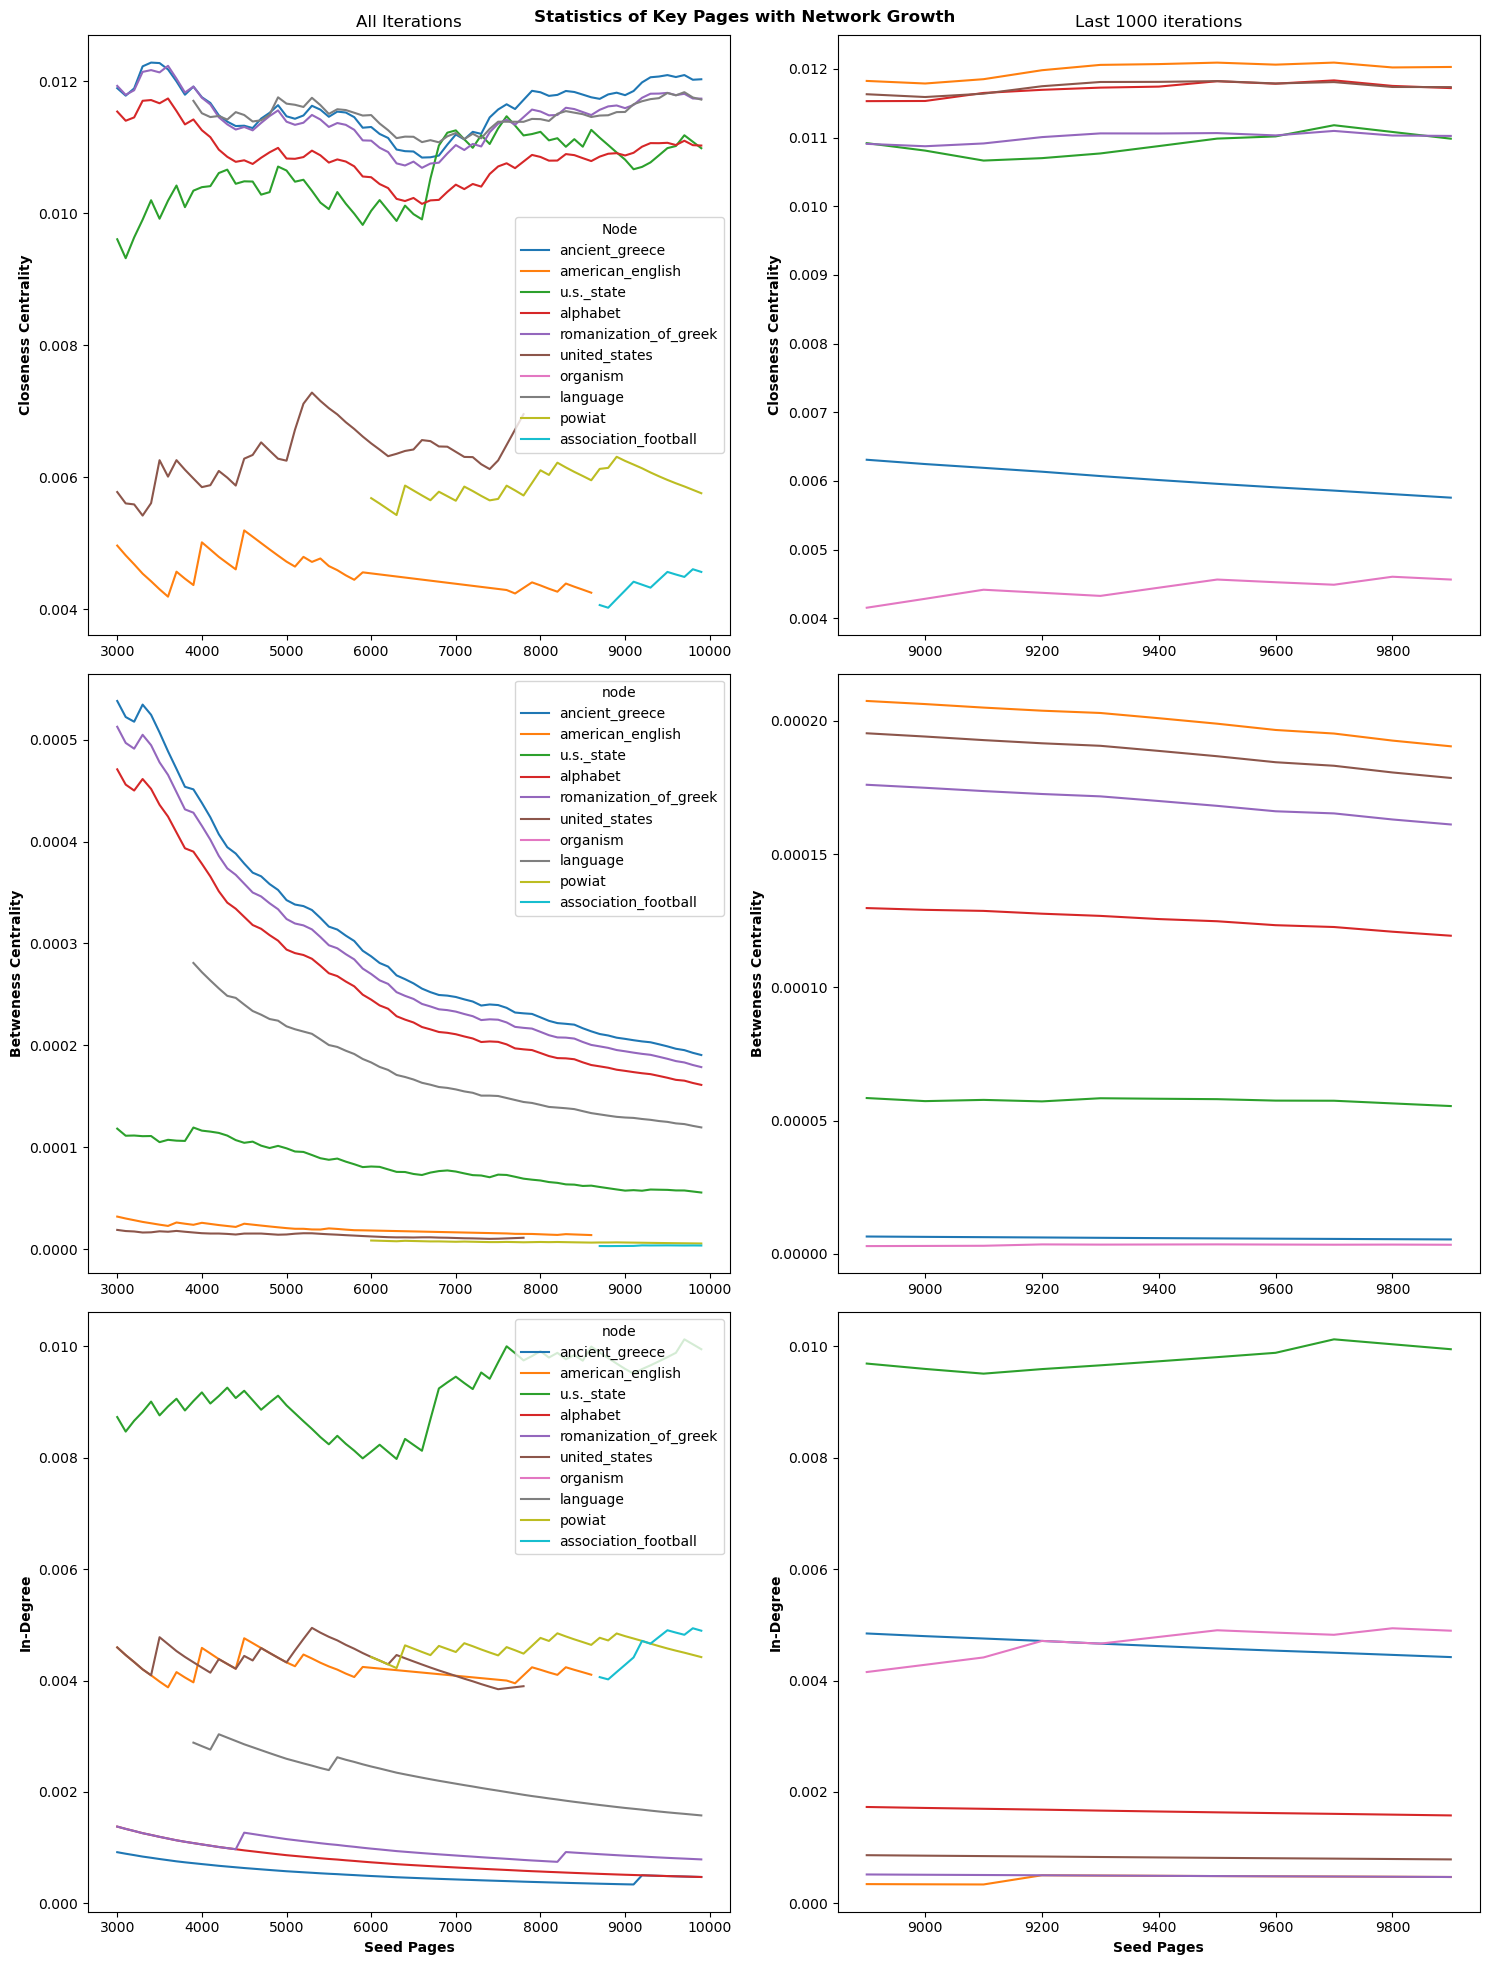

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
sns.lineplot(convergence_df2, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,0])
axs[0,0].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,0].set_xlabel("")
axs[0,0].set_title("All Iterations")

legend = axs[0,0].legend()
legend.set_title("Node")

sns.lineplot(second_link_last_1000_iterations, x="iteration", y="closeness_centrality", hue="node", ax=axs[0,1], legend=False)
axs[0,1].set_ylabel("Closeness Centrality", fontweight='bold')
axs[0,1].set_xlabel("")
axs[0,1].set_title("Last 1000 Iterations")

sns.lineplot(convergence_df2, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,0])
axs[1,0].set_ylabel("Betweness Centrality", fontweight='bold')
axs[1,0].set_xlabel("")


sns.lineplot(second_link_last_1000_iterations, x="iteration", y="betweeness_centrality", hue="node", ax=axs[1,1], legend=False)
axs[1,1].set_ylabel("Betweness Centrality", fontweight='bold')
axs[1,1].set_xlabel("")

sns.lineplot(convergence_df2, x="iteration", y="in_degree", hue="node", ax=axs[2,0])
axs[2,0].set_ylabel("In-Degree", fontweight='bold')
axs[2,0].set_xlabel("Seed Pages", fontweight='bold')

sns.lineplot(second_link_last_1000_iterations, x="iteration", y="in_degree", hue="node", ax=axs[2,1], legend=False)
axs[2,1].set_ylabel("In-Degree", fontweight='bold')
axs[2,1].set_xlabel("Seed Pages", fontweight='bold')


plt.suptitle("Statistics of Key Pages with Network Growth", fontweight='bold')
plt.tight_layout()

Look into core decompositions for displaying the network. Force directed would be better but is slow. 
Switch it to a directed graph.

In [9]:
# ------------------------------
# NETWORK PLOTTING FUNCTION
# ------------------------------
def plot_network(G, node_color="degree", layout="random"):
    # INITALIZE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)

    # NODE COLORS
    cmap = plt.cm.get_cmap("Greens")

    # DEGREE
    if node_color == "degree":
        centrality = list(dict(nx.degree(G)).values())

    # BETWENNESS
    if node_color == "betweeness":
        centrality = list(dict(nx.betweenness_centrality(G, endpoints="philosophy")).values())

    # CLOSENESS
    if node_color == "closeness":
        centrality = list(dict(nx.closeness_centrality(G)).values())

    # NODE SIZE CAN COLOR
    node_colors = [cmap(u / (0.01 + max(centrality))) for u in centrality]
    node_sizes = [10000 * u / (0.001 + max(centrality)) for u in centrality]

    scaled_node_sizes = [size if size > 3000 else 100 for size in node_sizes]

    scale = [size / max(node_sizes) for size in scaled_node_sizes]

    # POSITIONS LAYOUT
    N = len(G.nodes)
    if layout == "spring":
        # pos=nx.spring_layout(G,k=50*1./np.sqrt(N),iterations=100)
        pos = nx.spring_layout(G, scale=scale)

    if layout == "random":
        pos = nx.random_layout(G)

    if layout == "spiral":
        pos = nx.spiral_layout(G, scale=scale)

    if layout == "spectral":
        pos = nx.spectral_layout(G, scale=scale)
    
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)

    # PLOT NETWORK
    nx.draw(
        G,
        edgecolors="black",
        node_color=node_colors,
        node_size=scaled_node_sizes,
        pos=pos,
        with_labels=True
    )

    plt.show()


# G.remove_edges_from(nx.selfloop_edges(G))
# plot_network(nx.k_core(G, 50), node_color="degree", layout="spectral")


In [10]:
degree_dict = dict(G.in_degree())

# Create a dataframe with nodes and their degrees
df_nodes = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])

# Sort the dataframe by degree in descending order
df_nodes_sorted = df_nodes.sort_values(by='Degree', ascending=False)

df_nodes_sorted.head(10)

Degree
county_(united_states)      41
public_university           32
biology                     30
association_football        30
u.s._state                  29
sport                       27
united_states               24
physics                     22
capital_city                21
family_(biology)            21

In [236]:
def fail_fixer(G, fail, next_link, seen_pages):
    clean_name = fail.lstrip("!fail!: ")
    G = nx.relabel_nodes(G, {fail:clean_name})
    G.add_node(next_link)
    G.add_edge(clean_name, next_link)

    page_url = "https://en.wikipedia.org/wiki/" + next_link

    if next_link != "philosophy":
        philosophy_page = False
        old_page = next_link
    else: philosophy_page = True

    while not philosophy_page:
        full_first_link = get_first_link(page_url=page_url)
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            philosophy_page = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            philosophy_page = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link

    # fails = fails[True if f[0]!=fail else False for f in fails]

    return G, seen_pages

In [11]:
# Calculate the degrees of each node
degrees = dict(G.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by degree:
county_(united_states): 42
public_university: 33
biology: 31
association_football: 31
u.s._state: 30
sport: 28
united_states: 25
physics: 23
family_(biology): 22
capital_city: 22


In [12]:
# Calculate the degrees of each node
in_degree = dict(nx.in_degree_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by in_degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by in_degree:
county_(united_states): 0.006900033658700774
public_university: 0.005385392123864019
biology: 0.005048805116122518
association_football: 0.005048805116122518
u.s._state: 0.004880511612251767
sport: 0.004543924604510266
united_states: 0.004039044092898014
physics: 0.003702457085156513
family_(biology): 0.0035341635812857625
capital_city: 0.0035341635812857625


In [13]:
neighbors = [n[0] for n in list(G.in_edges("philosophy"))]
neighbor_degrees = [G.in_edges(n) for n in neighbors]
neighbors

['awareness',
 'philosophy_of_logic',
 'medical_specialty',
 'naturalism_(philosophy)',
 'philosophical_tradition',
 'metaphysics',
 'aesthetics',
 'philosophy_of_culture',
 'ethics',
 'object_(philosophy)',
 'american_enlightenment',
 'philosophies']

In [14]:
# Calculate the degrees of each node
betweeness_centrality = dict(nx.betweenness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by betweeness centrality:")
for node, betweeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {betweeness_centrality}")

Top nodes by betweeness centrality:
hathor_27: 0.0002776375410599607
hathor_28: 0.00027760921358918627
hathor_26: 0.00027760921358918627
hathor_29: 0.00027752423117686305
hathor_25: 0.00027752423117686305
hathor_30: 0.00027738259382299106
hathor_24: 0.00027738259382299106
koiak_1: 0.0002771843015275702
hathor_23: 0.0002771843015275702
koiak_2: 0.0002769293542906005


In [15]:
# Calculate the degrees of each node
closeness_centrality = dict(nx.closeness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by closeness centrality:")
for node, closeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {closeness_centrality}")

Top nodes by closeness centrality:
philosophy: 0.055613864086616734
awareness: 0.05010252414286812
science: 0.04418291764624696
knowledge: 0.04086479663029994
geography: 0.025785069299941156
continent: 0.023577836440967923
state_(polity): 0.020007060563283153
physics: 0.01831940481488967
politics: 0.017827898047171872
natural_science: 0.017531459694222526


In [16]:
distance_from_phil = []
path_to_phil = []
nodes = []
for node in G.nodes:
    try:
        shortest_path = nx.shortest_path(G, node, "philosophy")
        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        nodes.append(node)
        distance_from_phil.append(shortest_path_length)
        path_to_phil.append(shortest_path)
    except nx.NetworkXNoPath:
        shortest_path = np.NAN
        shortest_path_length = np.NAN
        continue


# nodes  = [n for n in G.nodes]
df = pd.DataFrame(
    {"node": nodes, "distance": distance_from_phil, "shortest_path": path_to_phil}
)
print("AVERAGE DISTANCE TO PHILOSOPHY: ", np.mean(distance_from_phil))
df.sort_values("distance", inplace=True)
df.reset_index(inplace=True)
df.pop("index")
nodes = df["node"]
distances = df["distance"]
paths = df["shortest_path"]
print(
    "FURTHEST NODE: ",
    nodes[len(nodes) - 1],
    " is ",
    distances[len(distances) - 1],
    " pages away with a path of: ",
    paths[len(distances) - 1],
)
print(
    "THERE ARE "
    + str(
        sum([True if distance == max(distances) else False for distance in distances])
    )
    + " paths with a distance of "
    + str(max(distances))
)


AVERAGE DISTANCE TO PHILOSOPHY:  14.325591216216216
FURTHEST NODE:  paremhat_6  is  198  pages away with a path of:  ['paremhat_6', 'paremhat_5', 'paremhat_4', 'paremhat_3', 'paremhat_2', 'paremhat_1', 'meshir_30', 'meshir_29', 'meshir_28', 'meshir_27', 'meshir_26', 'meshir_25', 'meshir_24', 'meshir_23', 'meshir_22', 'meshir_21', 'meshir_20', 'meshir_19', 'meshir_18', 'meshir_17', 'meshir_16', 'meshir_15', 'meshir_14', 'meshir_13', 'meshir_12', 'meshir_11', 'meshir_10', 'meshir_9', 'meshir_8', 'meshir_7', 'meshir_6', 'meshir_5', 'meshir_4', 'meshir_3', 'meshir_2', 'meshir_1', 'tobi_30', 'tobi_29', 'tobi_28', 'tobi_27', 'tobi_26', 'tobi_25', 'tobi_24', 'tobi_23', 'tobi_22', 'tobi_21', 'tobi_20', 'tobi_19', 'tobi_18', 'tobi_17', 'tobi_16', 'tobi_15', 'tobi_14', 'tobi_13', 'tobi_12', 'tobi_11', 'tobi_10', 'tobi_9', 'tobi_8', 'tobi_7', 'tobi_6', 'tobi_5', 'tobi_4', 'tobi_3', 'tobi_2', 'tobi_1', 'koiak_30', 'koiak_29', 'koiak_28', 'koiak_27', 'koiak_26', 'koiak_25', 'koiak_24', 'koiak_23', 

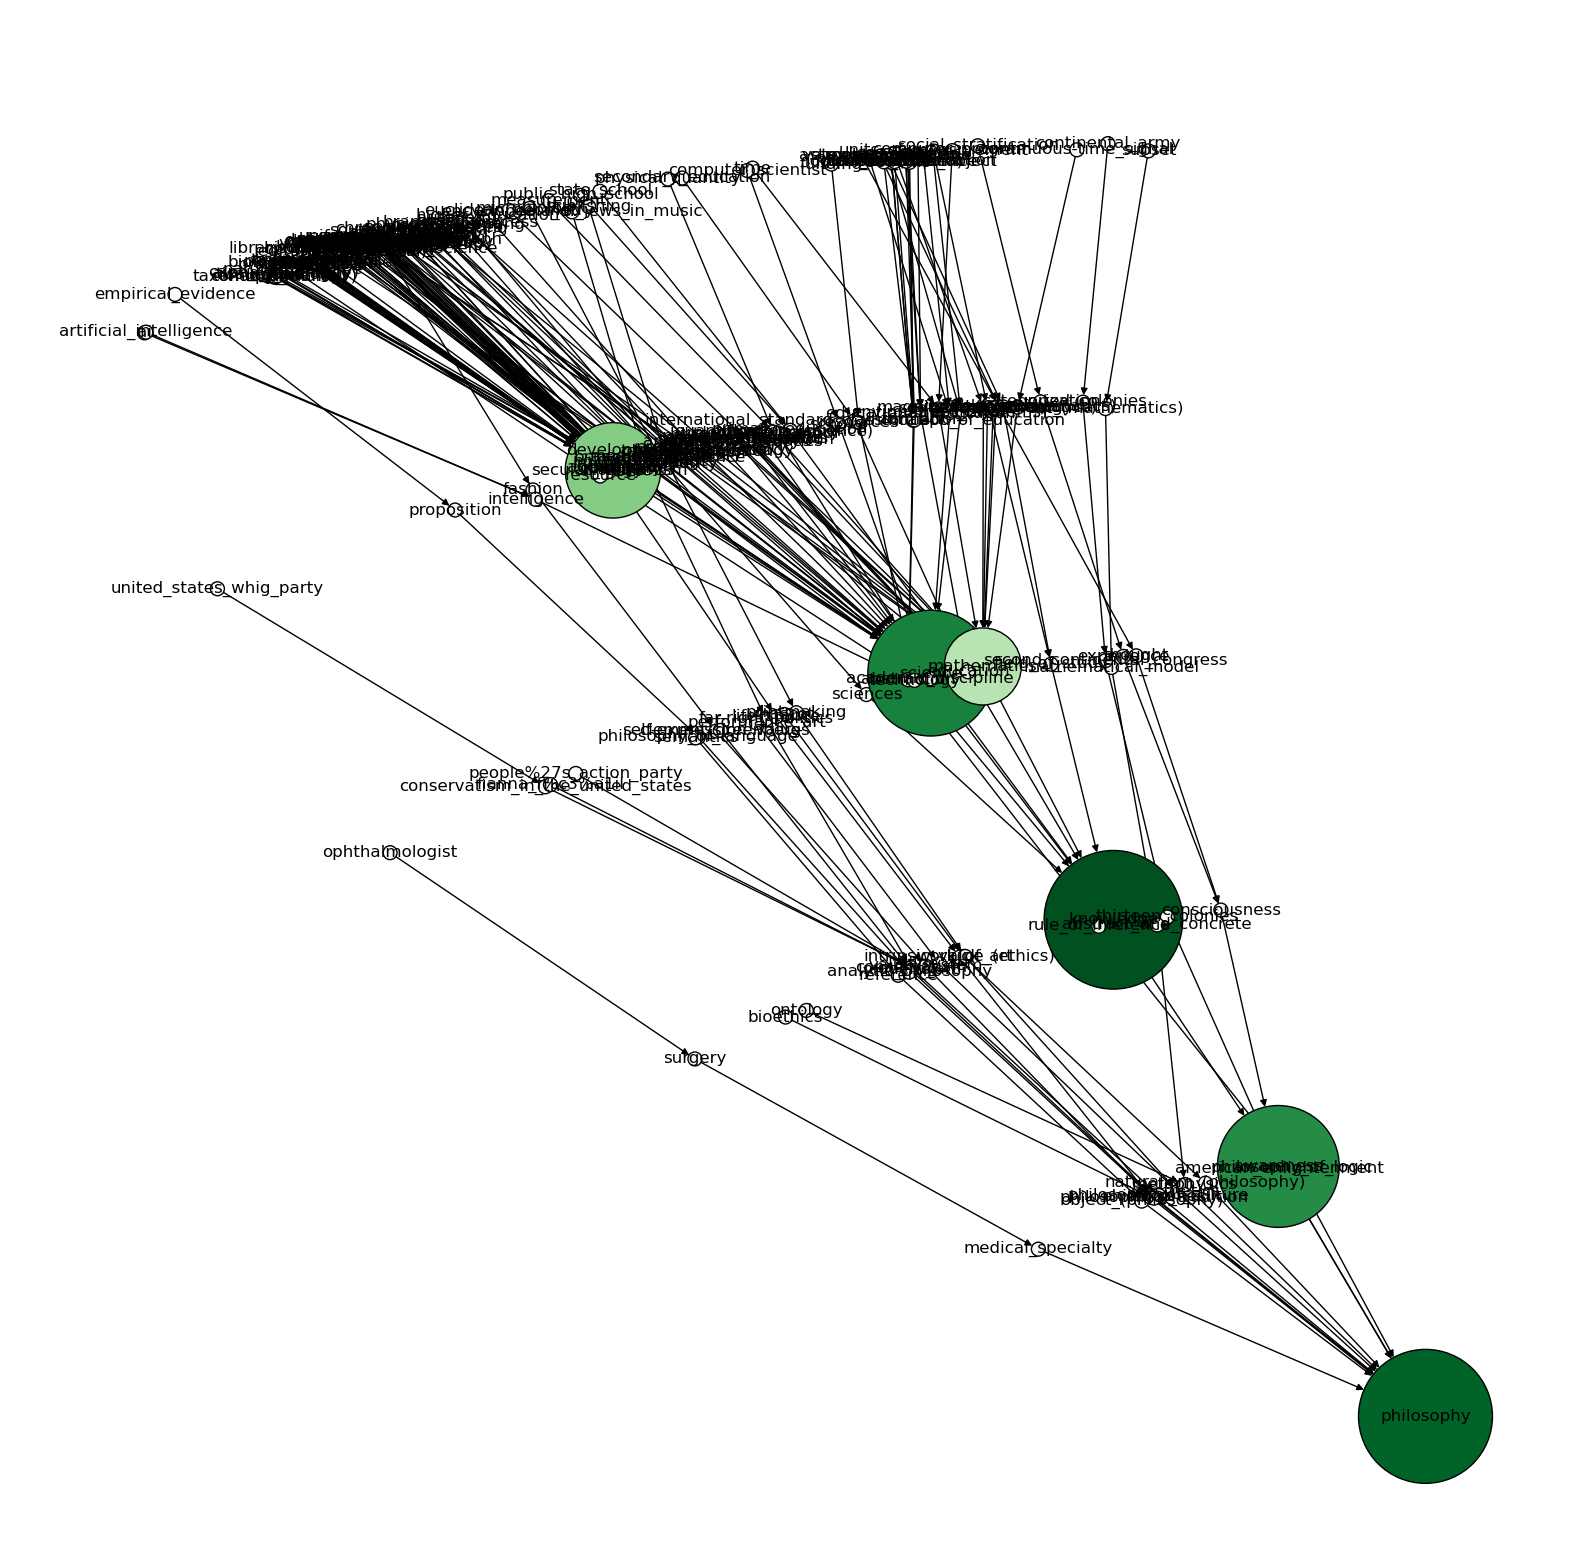

In [17]:
five_away = df[df['distance'] <= 5]

subgraph = G.subgraph(five_away['node'])

plot_network(subgraph, node_color="closeness", layout="kamada_kawai")

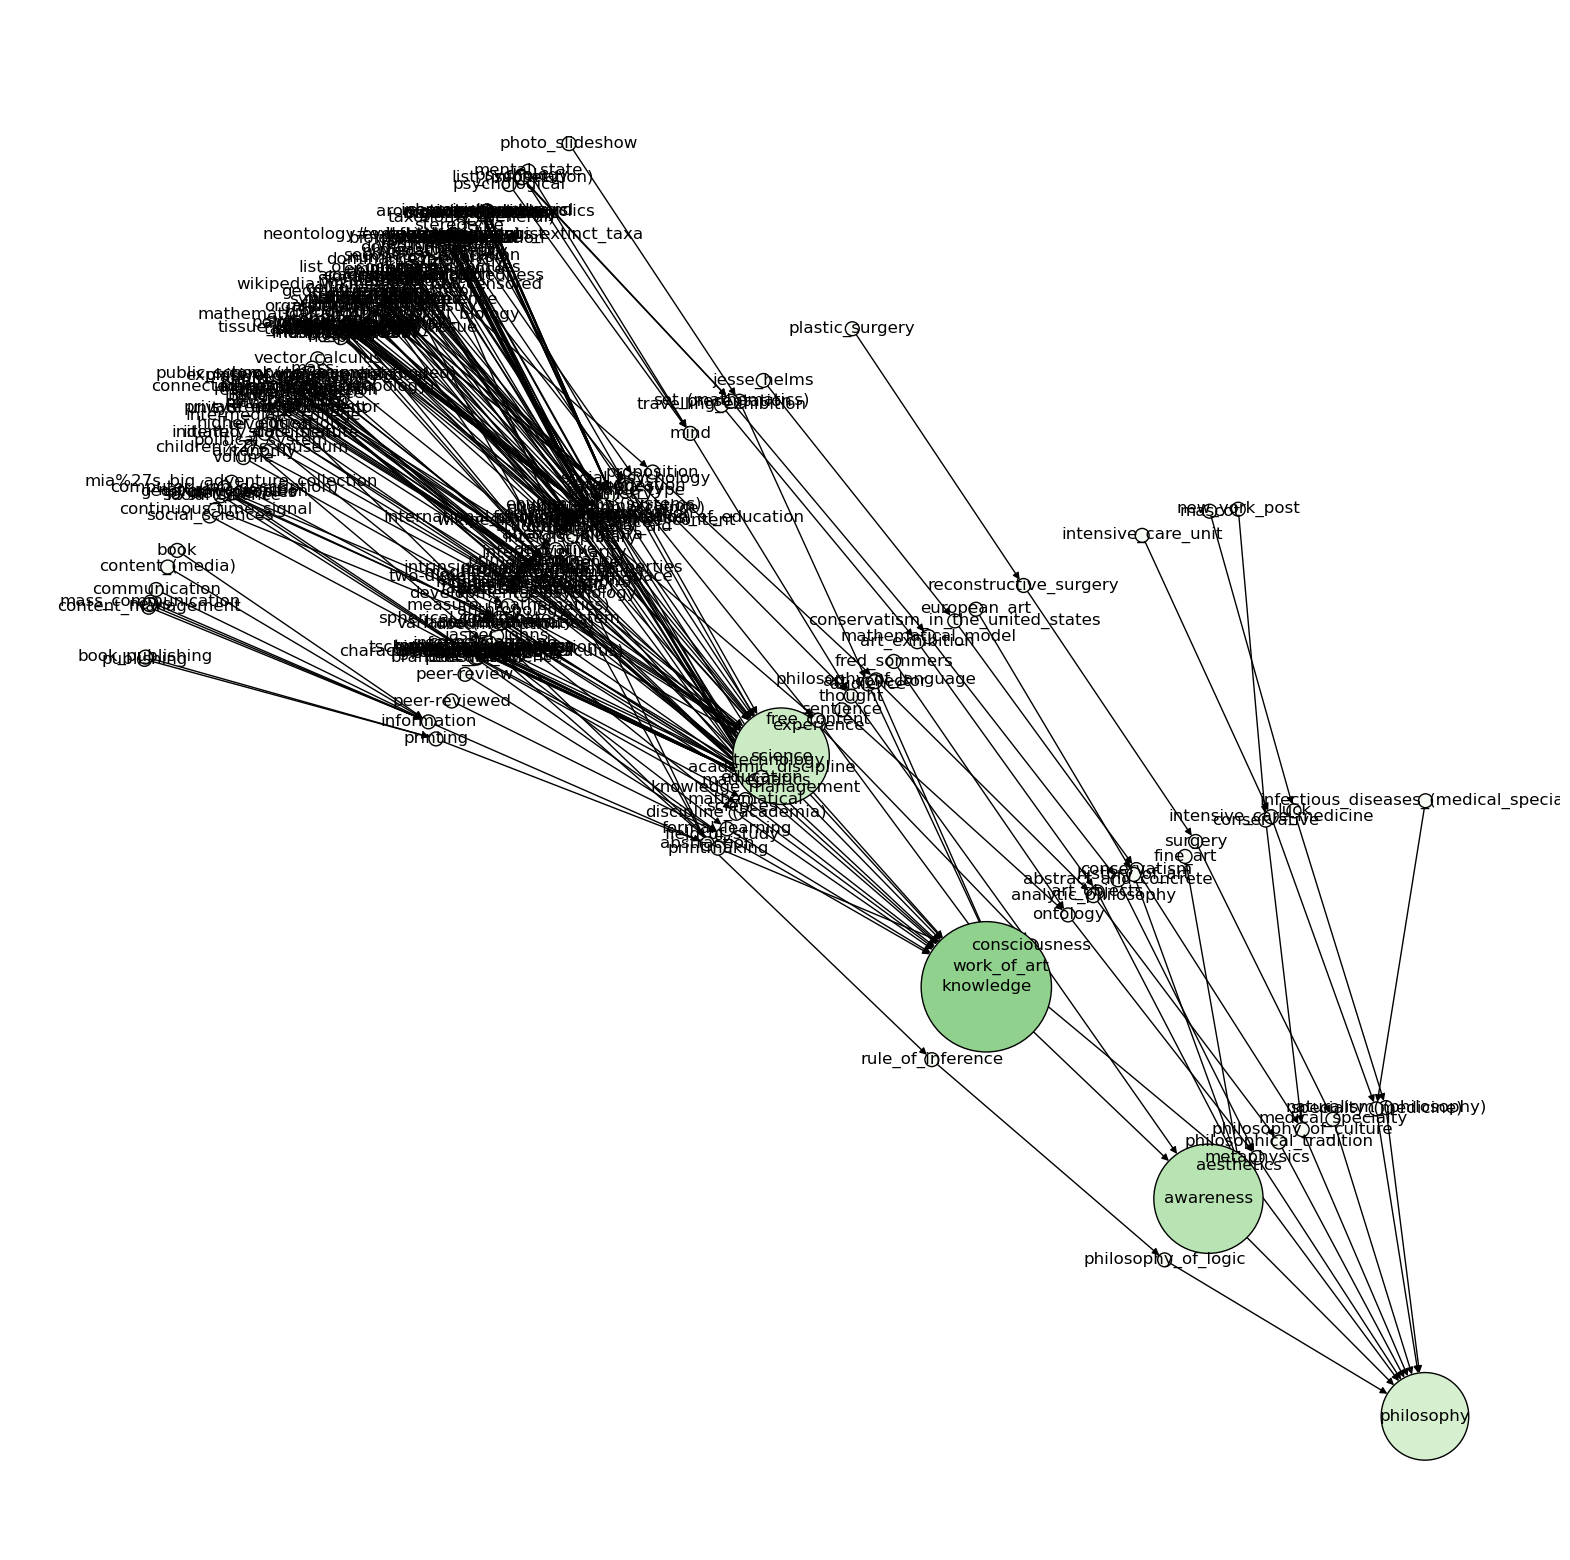

In [121]:
plot_network(subgraph, node_color="betweeness", layout="kamada_kawai")

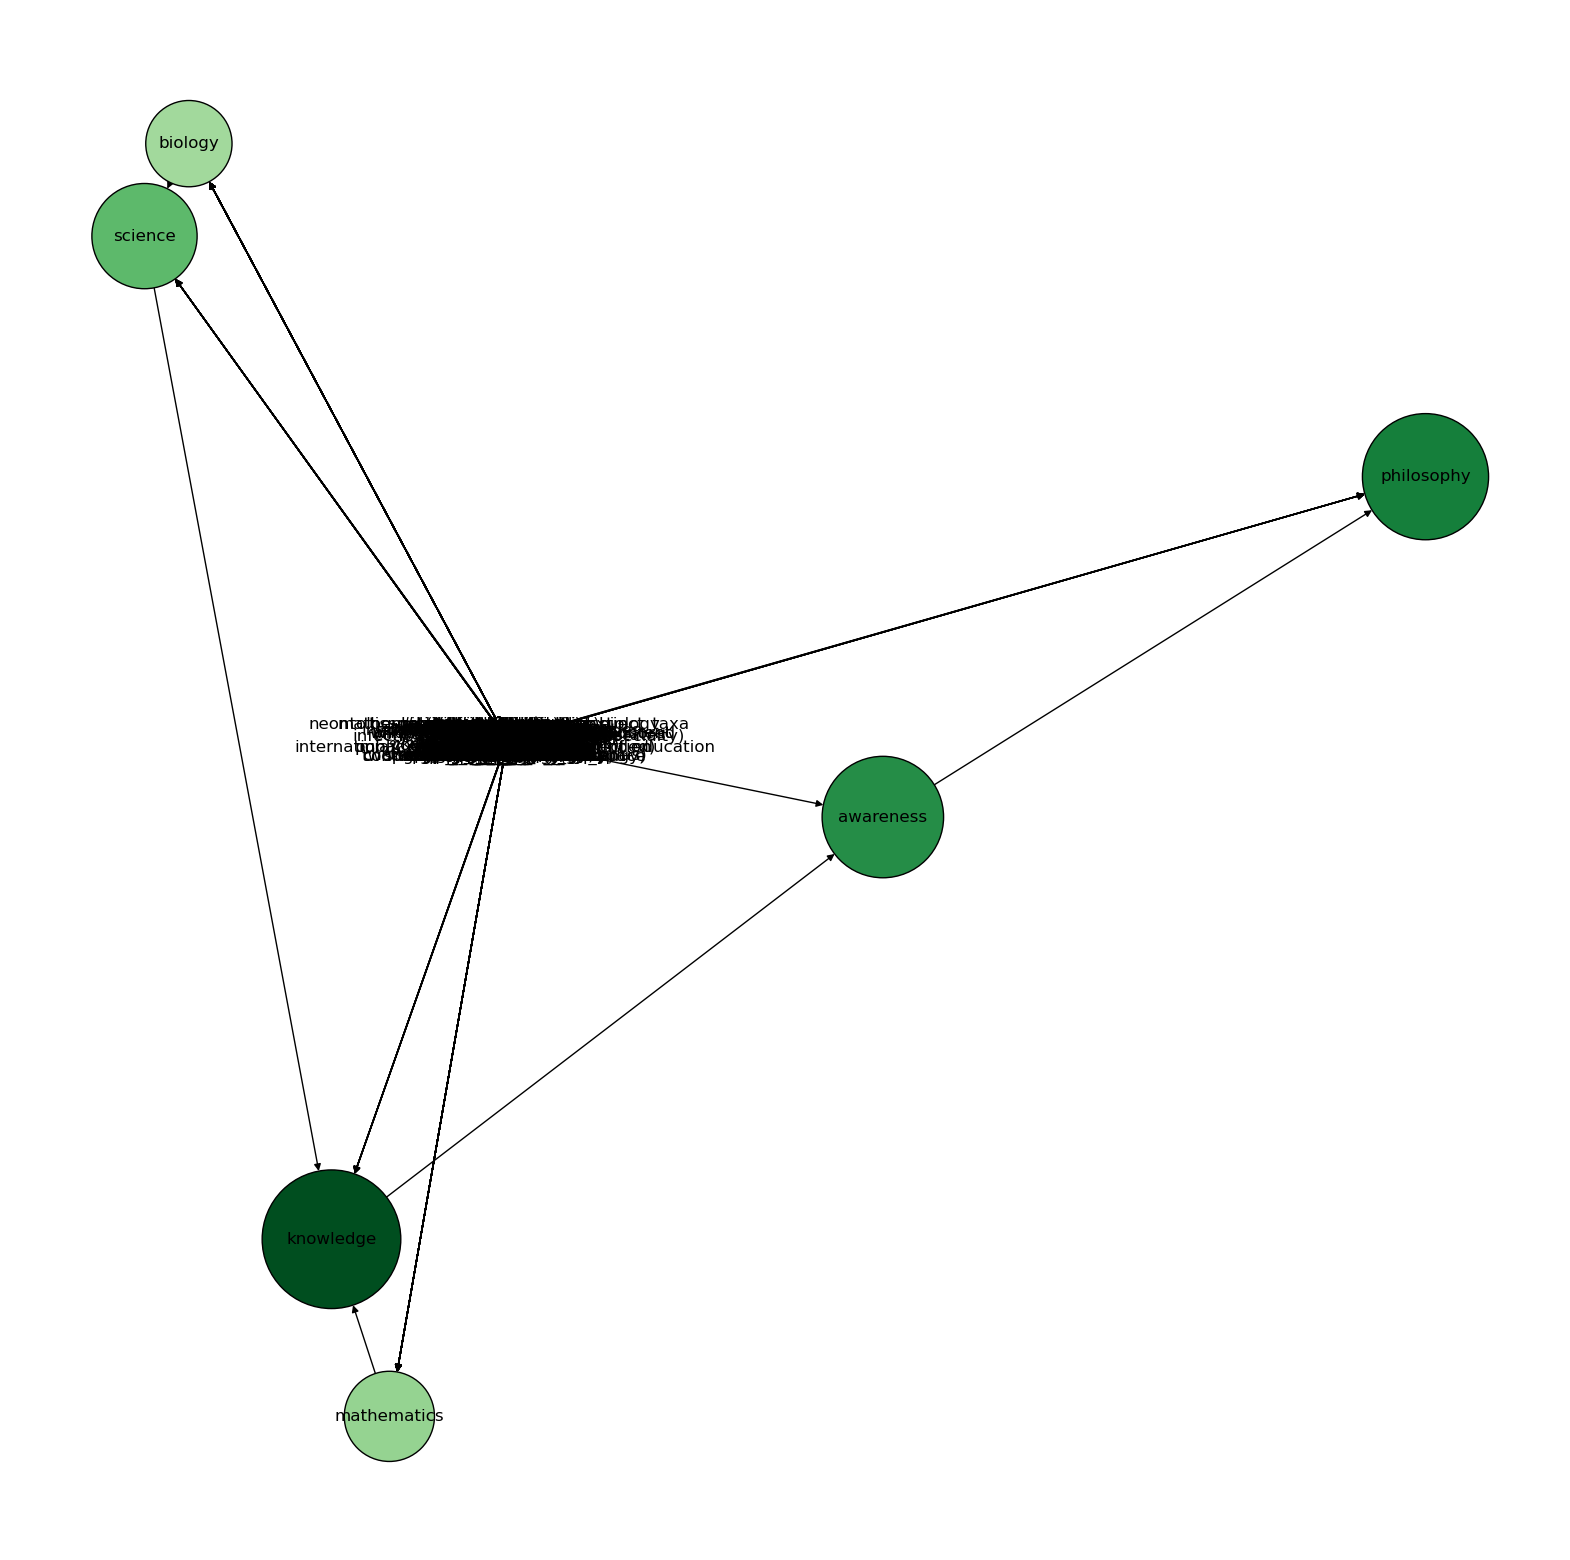

In [122]:
plot_network(subgraph, node_color="closeness", layout="spectral")

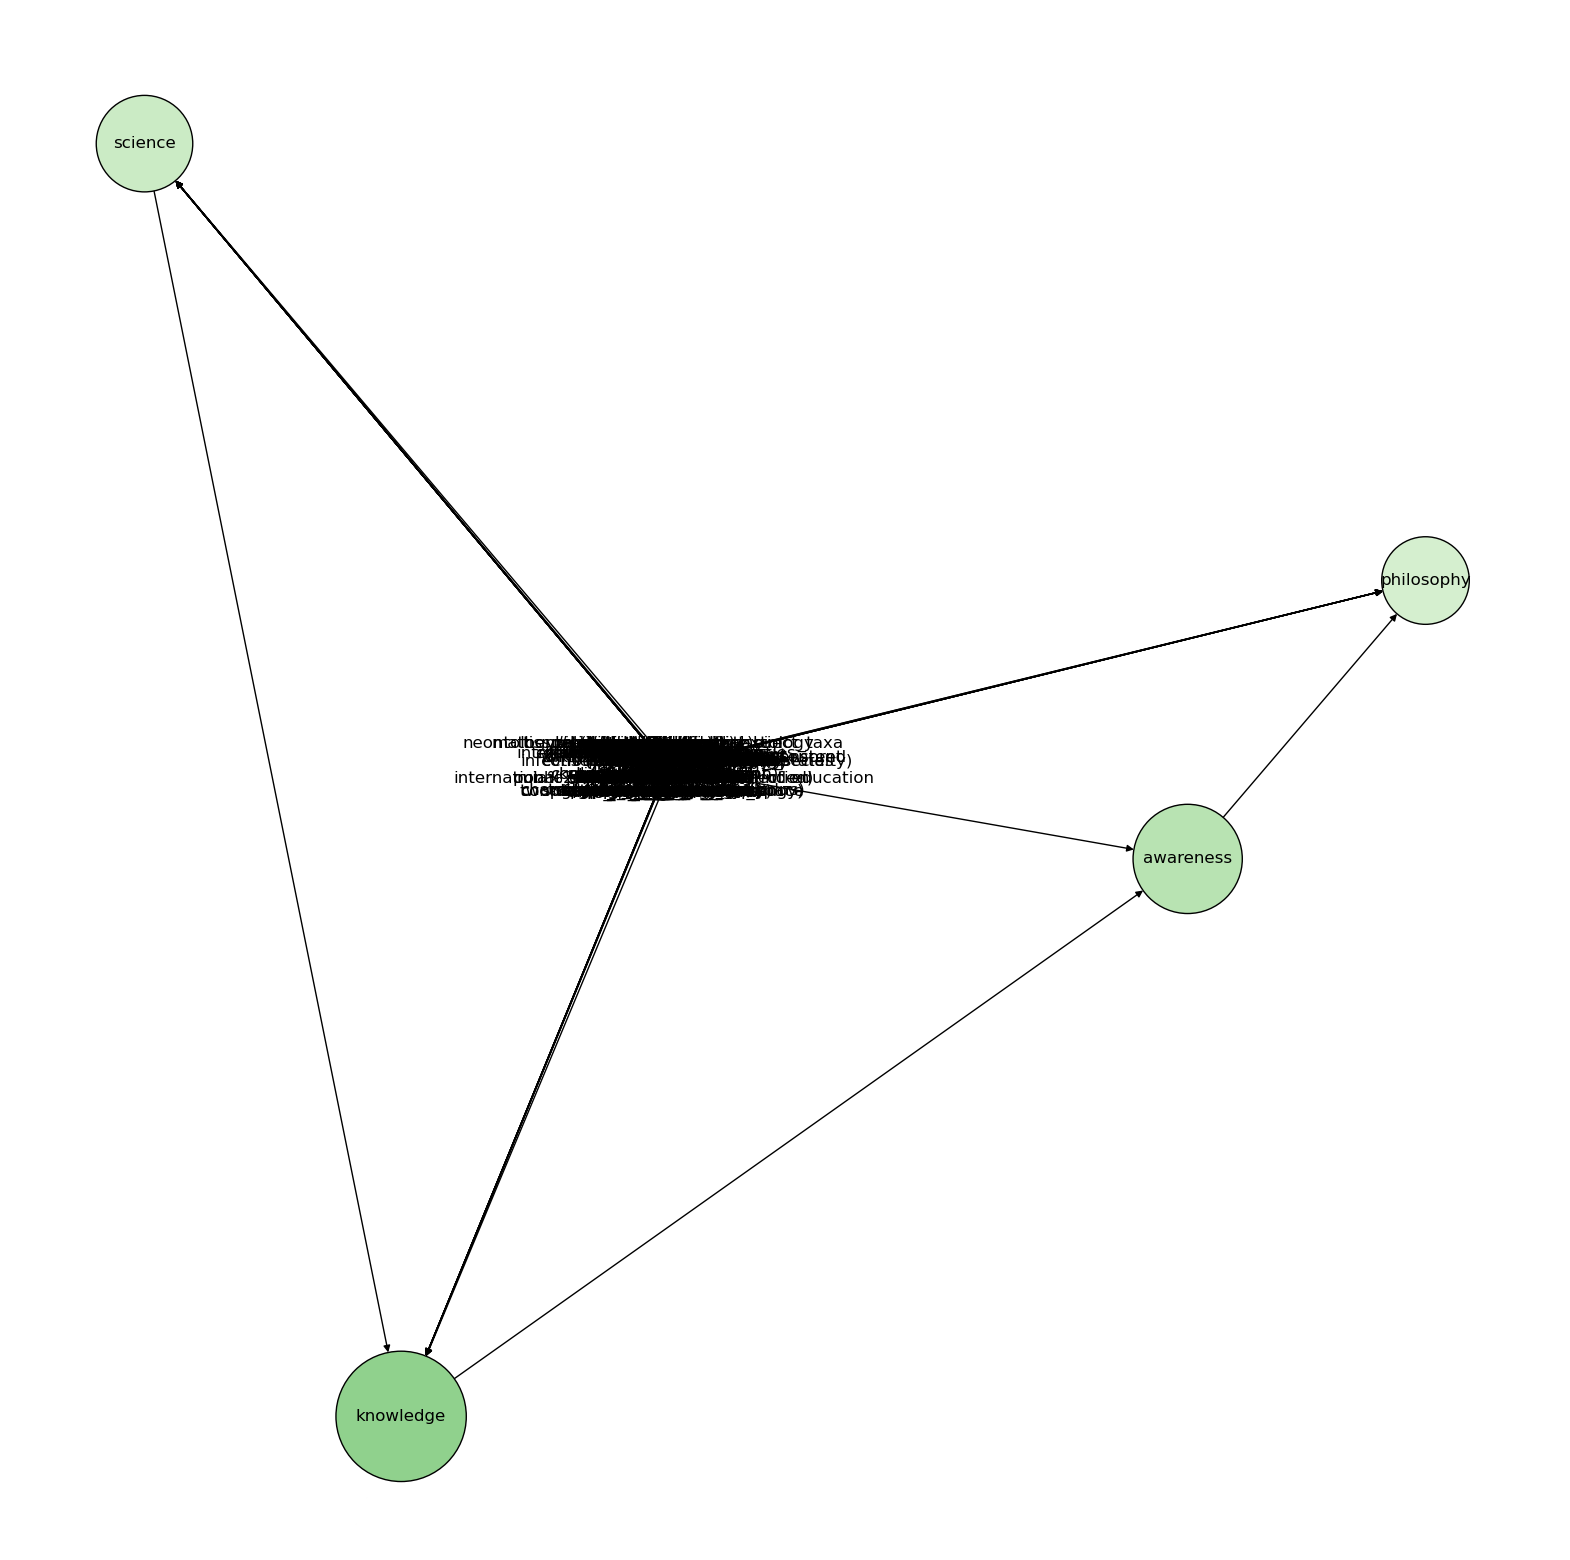

In [123]:
plot_network(subgraph, node_color="betweeness", layout="spectral")

In [124]:
path_appearances = []
for node in G.nodes:
    count = 0
    for path in paths:
        if node in path:
            count +=1
    
    path_appearances.append(count)

path_count_df = pd.DataFrame({"node":G.nodes, "appearances":path_appearances})
path_count_df = path_count_df.sort_values("appearances", ascending=False)
path_count_df.reset_index(inplace=True)
path_count_df.pop("index")

# Remove philosophy
path_count_df = path_count_df[1:]
path_count_df.head(80)

node  appearances
1     philosophy_of_logic         4304
2       rule_of_inference         4303
3             abstraction         4302
4             information         4253
5           communication         4182
..                    ...          ...
76  variety_(linguistics)          184
77              intention          173
78             psychology          170
79                  trade          165
80               business          164

[80 rows x 2 columns]

In [15]:
def isolate_gcc(G):
    # Get all strongly connected components as subgraphs
    sccs = list(nx.weakly_connected_components(G))

    sorted_scc = sorted(sccs, key=len, reverse=True)
    # Find the largest strongly connected component (GCC)
    gcc_nodes = sorted_scc[0]

    # Create a subgraph containing only nodes from the GCC
    gcc = G.subgraph(gcc_nodes)

    return gcc

weak_gcc = isolate_gcc(G)
fraction = round((len(weak_gcc.nodes()) / len(G.nodes())) * 100, 2)
print("GCC PERCENTAGE OF NETWORK: ", fraction, "%")

GCC PERCENTAGE OF NETWORK:  95.16 %


In [22]:
def isolate_gcc(G):
    # Get all strongly connected components as subgraphs
    sccs = list(nx.weakly_connected_components(G))

    sorted_scc = sorted(sccs, key=len, reverse=True)
    # Find the largest strongly connected component (GCC)
    gcc_nodes = sorted_scc[1]

    # Create a subgraph containing only nodes from the GCC
    gcc = G.subgraph(gcc_nodes)

    return gcc

weak_gcc = isolate_gcc(G)
# Calculate the degrees of each node
degrees = dict(weak_gcc.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by degree:
history_of_the_administrative_divisions_of_china: 3
provinces_of_china: 2
shandong: 2
province-level_divisions_of_china: 2
administrative_divisions_of_china: 2
pingyuan_county,_shandong: 1


In [23]:
get_first_link("https://en.wikipedia.org/wiki/souk")

'Marketplace'

Notable Disconnected nodes:

- Name
- Marketplace

In [26]:
G.add_edge("philosophical", "philosophy")

In [27]:
nx.shortest_path(G,"music","philosophy")

['music',
 'the_arts',
 'creativity',
 'psychology',
 'mind',
 'thought',
 'consciousness',
 'awareness',
 'philosophy']

### Second Link Plots

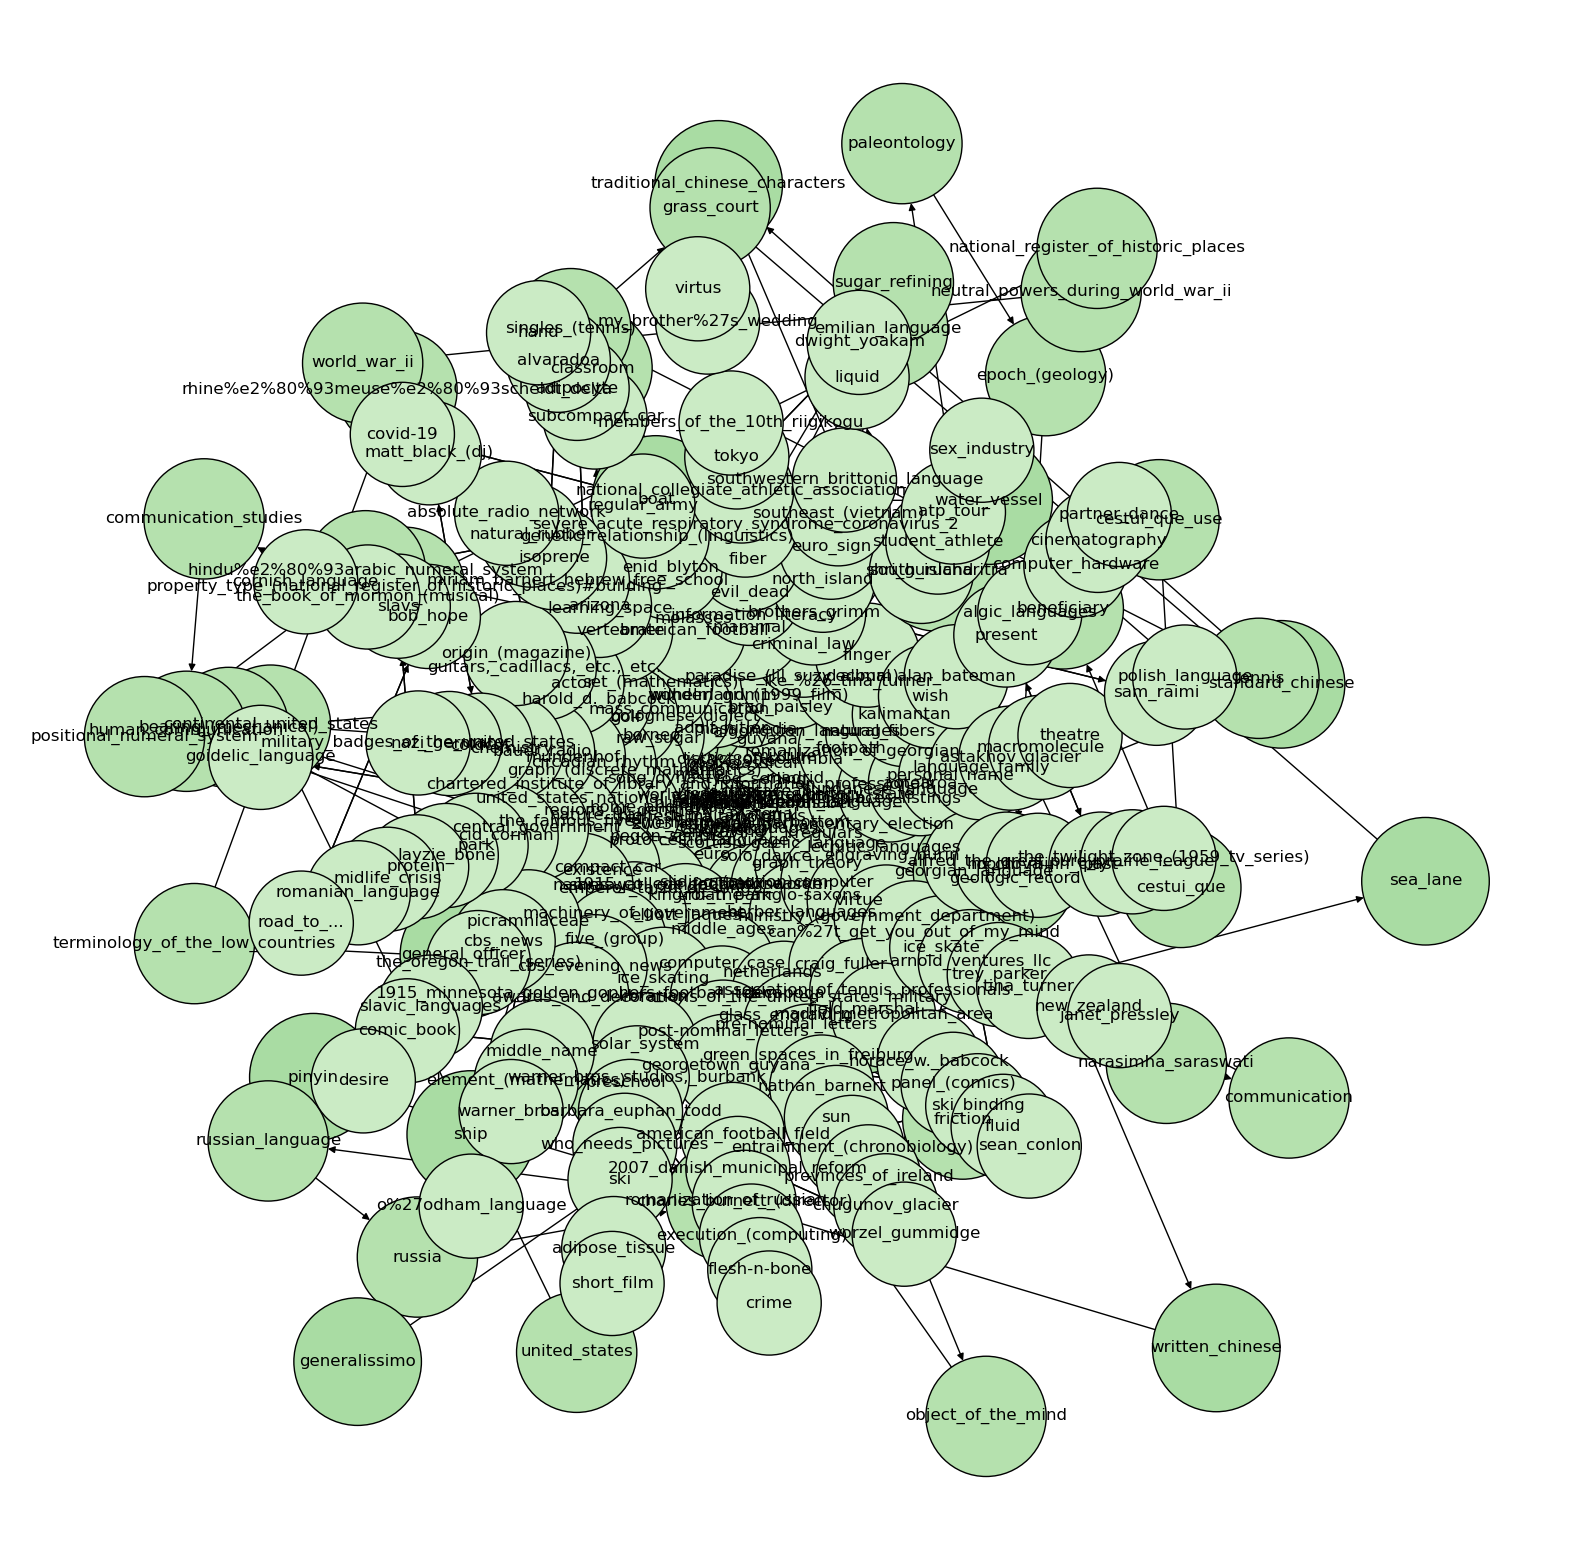

In [31]:
G2.remove_edges_from(nx.selfloop_edges(G2))
subgraph2 = nx.k_core(G2, 2)
plot_network(subgraph2, node_color="closeness", layout="spiral")

In [ ]:
path_appearances = []
for node in G2.nodes:
    count = 0
    for path in paths:
        if node in path:
            count +=1
    
    path_appearances.append(count)

path_count_df = pd.DataFrame({"node":G.nodes, "appearances":path_appearances})
path_count_df = path_count_df.sort_values("appearances", ascending=False)
path_count_df.reset_index(inplace=True)
path_count_df.pop("index")

# Remove philosophy
path_count_df = path_count_df[1:]
path_count_df.head(80)

In [34]:
# Calculate the degrees of each node
degrees = dict(G2.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by degree:
u.s._state: 65
association_football: 32
powiat: 29
american_english: 27
united_states: 22
german_language: 19
romanization_of_arabic: 18
pinyin: 16
research_university: 16
french_language: 15


In [35]:
# Calculate the degrees of each node
in_degree = dict(nx.in_degree_centrality(G2))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by in_degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by in_degree:
u.s._state: 0.010018785222291797
association_football: 0.004852849092047589
powiat: 0.004383218534752661
american_english: 0.004070131496556042
united_states: 0.003287413901064496
german_language: 0.002817783343769568
romanization_of_arabic: 0.0026612398246712585
pinyin: 0.00234815278647464
research_university: 0.00234815278647464
french_language: 0.0021916092673763305


In [37]:
# Calculate the degrees of each node
betweeness_centrality = dict(nx.betweenness_centrality(G2))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by betweeness centrality:")
for node, betweeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {betweeness_centrality}")

Top nodes by betweeness centrality:
ancient_greece: 0.00016919052956562225
romanization_of_greek: 0.0001566660676493492
alphabet: 0.00013914162485065008
ancient_greek_language: 0.00013406811483760014
organism: 0.0001318377312086748
letter_(alphabet): 0.00012044071596196839
animal: 0.00011884758479845029
state_(polity): 0.00011838190030449884
population: 0.00011529367681829452
eukaryotic: 0.00011264662811583368


In [38]:
# Calculate the degrees of each node
closeness_centrality = dict(nx.closeness_centrality(G2))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by closeness centrality:")
for node, closeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {closeness_centrality}")

Top nodes by closeness centrality:
ancient_greece: 0.012006887914840326
romanization_of_greek: 0.011707771688833152
language: 0.011671205885298276
u.s._state: 0.011010013652647895
alphabet: 0.010995510457588542
grammar: 0.010852667652139918
linguistics: 0.010761638436764389
letter_(alphabet): 0.010300499059633223
natural_language: 0.010240507849732912
language_studies: 0.010114373742803153


### Network Structures

/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  # AVERAGE DEGREE
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:159: UserWarning: FixedFormatter should only be used together with FixedLocator
  directed = nx.is_directed(G)
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  "AVEREAGE DEGREE CONNECTIVITY: "
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:211: UserWarning: FixedFormatter should only be used together with FixedLocator
  degree_sequence = sorted([d for _, d in data], reverse=True)
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xlabel(xlabel_start + "Degree\n(log scale)")


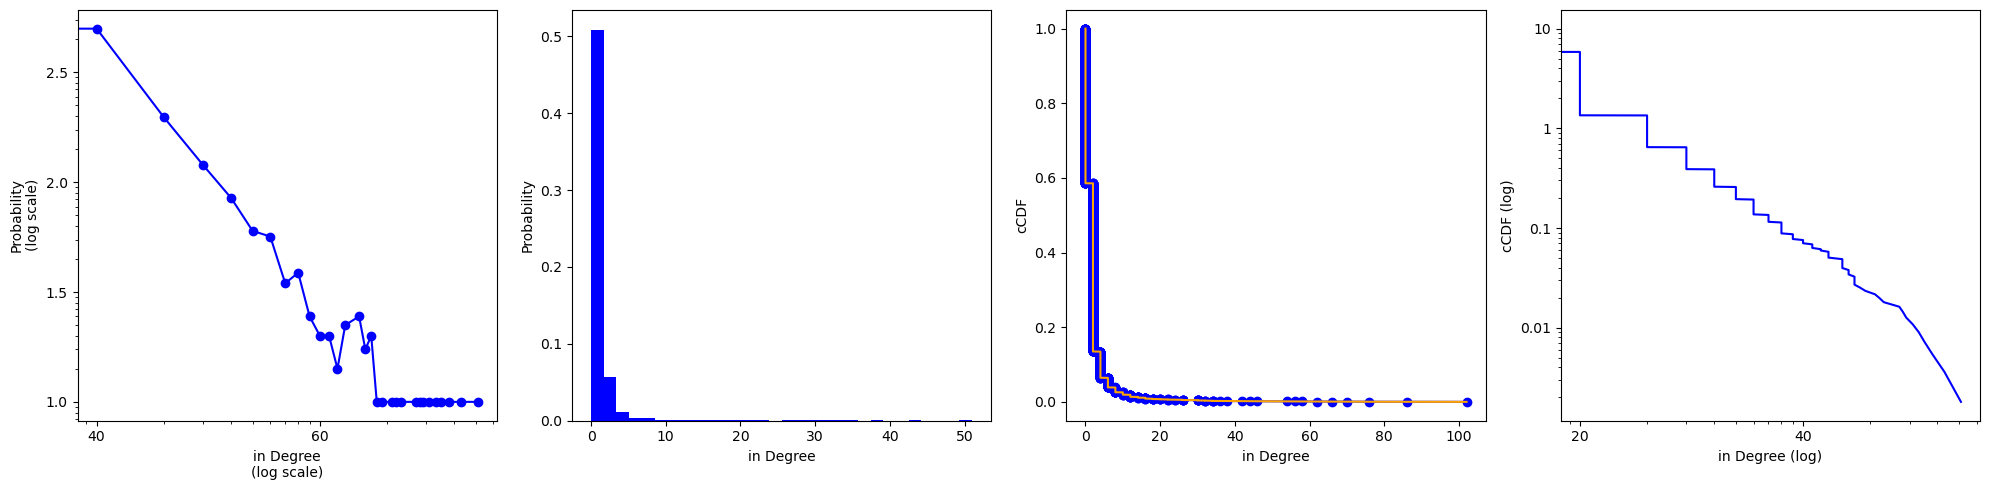

AVEREAGE IN DEGREE CONNECTIVITY: 2.0773339998767786
AVEREAGE OUT DEGREE CONNECTIVITY: 3.217170785687938


In [50]:
from importlib import reload 
import nx_tools as nxt
reload(nxt)

nxt.plot_degree_distribution(G)
nxt.ave_degree(G)

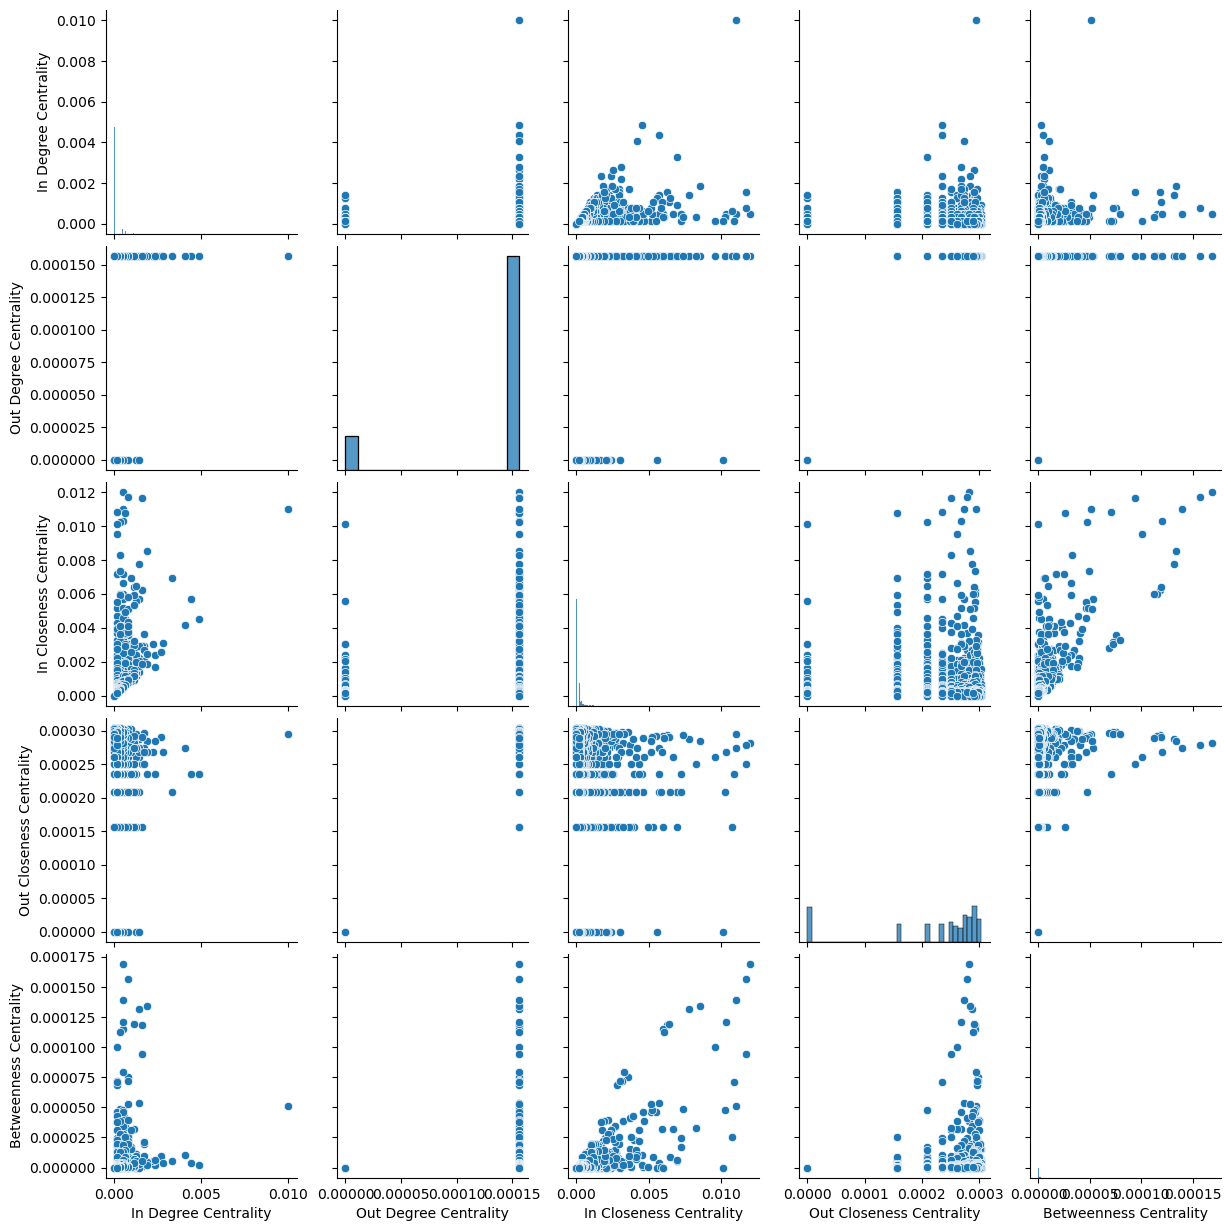

/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:155: UserWarning: FixedFormatter should only be used together with FixedLocator
  # AVERAGE DEGREE
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:159: UserWarning: FixedFormatter should only be used together with FixedLocator
  directed = nx.is_directed(G)
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  "AVEREAGE DEGREE CONNECTIVITY: "
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:211: UserWarning: FixedFormatter should only be used together with FixedLocator
  degree_sequence = sorted([d for _, d in data], reverse=True)
/Users/Austin/Desktop/Data Science/645-final-project/code/nx_tools.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xlabel(xlabel_start + "Degree\n(log scale)")


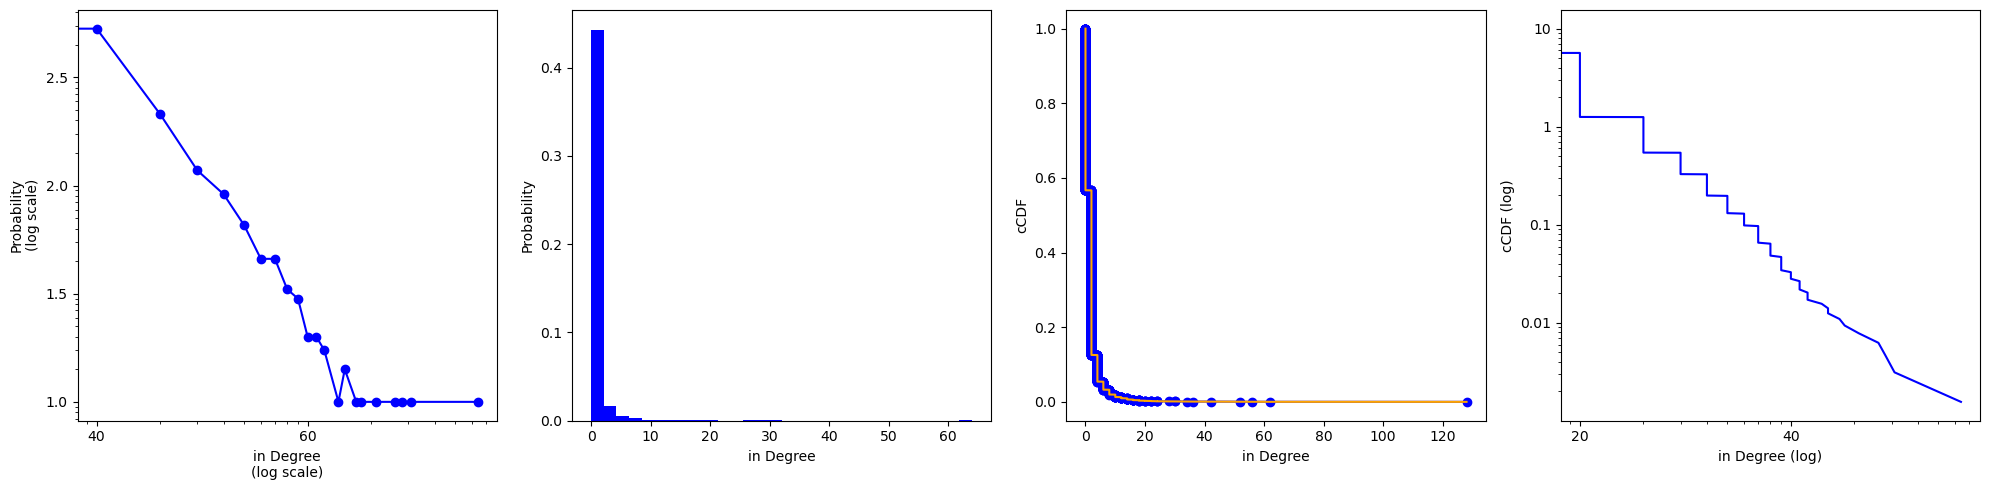

AVEREAGE IN DEGREE CONNECTIVITY: 1.8268825028152322
AVEREAGE OUT DEGREE CONNECTIVITY: 2.389060512447756


In [51]:
nxt.plot_centrality_correlation(G2)
nxt.plot_degree_distribution(G2)
nxt.ave_degree(G2)